# Cox生存分析

* `mydir`：自己的数据
* `ostime_column`: 数据对应的生存时间，不一定非的是OST，也可以是DST、FST等。
* `os`：生存状态，不一定非的是OS，也可以是DS、FS等。

In [1]:
import os
from IPython.display import display
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd
import pandas as pd

os.makedirs('img', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('features', exist_ok=True)

# 设置数据目录
survival_type = 'DFS'
task_type = f'MIL-{survival_type}_'
# 对应的标签文件
group_info = get_param_in_cwd('dataset_column') or 'group'
survival_data = pd.read_csv(get_param_in_cwd('survival_file'))[['ID', survival_type, f"{survival_type}TIME"]]
labelf = 'group.csv'
# 读取标签数据列名
labels = [get_param_in_cwd('task_column') or 'label']

# 读取特征

In [2]:
from collections import namedtuple
import onekey_algo.custom.components as okcomp
from onekey_algo import OnekeyDS as okds
from onekey_algo.custom.utils import print_join_info
from onekey_algo import get_param_in_cwd

import pandas as pd
import numpy as np
import os
os.makedirs('img', exist_ok=True)
os.makedirs('features', exist_ok=True)


prob_histo = pd.read_csv(f'features/rad_prob_histogram.csv')
prob_tfidf = pd.read_csv(f'features/rad_prob_tfidf.csv')
prob = pd.merge(prob_histo, prob_tfidf, on='ID', how='inner', suffixes=['_histo', '_tfidf'])
prob['ID'] = prob['ID'].astype(str)

pred_histo = pd.read_csv(f'features/rad_pred_histogram.csv')
pred_tfidf = pd.read_csv(f'features/rad_pred_tfidf.csv')
pred = pd.merge(pred_histo, pred_tfidf, on='ID', how='inner', suffixes=['_histo', '_tfidf'])
pred['ID'] = pred['ID'].astype(str)

features = pd.merge(prob, pred, on='ID', how='inner')
features.to_csv('features/rad_features.csv', index=False, header=True)
labels = ['label']
featrues_not_use = ['ID']
features

,ID,prob-0.0,prob-0.01,prob-0.02,prob-0.03,prob-0.04,prob-0.05,prob-0.06,prob-0.07,prob-0.08,...,prob095,prob096,prob097,prob098,prob099,prob10,pred-0,pred-1,pred0,pred1
0,primary-1.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.286,0.714,0.129,0.992
1,primary-10.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
2,primary-100.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
3,primary-101.nii.gz,0.0,0.0,0.429,0.143,0.143,0.0,0.143,0.143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
4,primary-102.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,secondary2-70.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
499,secondary2-71.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
500,secondary2-72.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
501,secondary2-8.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.857,0.143,0.891,0.455


In [3]:
from lifelines import CoxPHFitter
import pandas as pd
from onekey_algo.custom.components.comp1 import normalize_df
from sklearn.model_selection import train_test_split
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.components.comp1 import fillna

event_col = survival_type
duration_col = f"{survival_type}TIME"
label_data = pd.read_csv(labelf)[['ID', 'group']]
data = pd.merge(features[[c for c in features.columns if c not in ['label']]], survival_data, on='ID', how='inner')
data = pd.merge(data, label_data, on='ID', how='inner')
data

,ID,prob-0.0,prob-0.01,prob-0.02,prob-0.03,prob-0.04,prob-0.05,prob-0.06,prob-0.07,prob-0.08,...,prob098,prob099,prob10,pred-0,pred-1,pred0,pred1,DFS,DFSTIME,group
0,primary-1.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.286,0.714,0.129,0.992,1,20,train
1,primary-10.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,0,48,train
2,primary-100.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.143,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,1,9,train
3,primary-101.nii.gz,0.0,0.0,0.429,0.143,0.143,0.0,0.143,0.143,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,0,55,val
4,primary-102.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,1,7,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,secondary2-69.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.714,0.286,0.632,0.775,0,40,test
454,secondary2-7.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.143,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,0,52,test
455,secondary2-71.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.143,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,0,39,test
456,secondary2-72.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,0,38,test


In [4]:
import os
from onekey_algo.custom.components.comp1 import normalize_df, select_feature

corr_name = get_param_in_cwd('corr_name', 'spearman')
if os.path.exists(f'features/{task_type}features_corrsel.csv') and False:
    data = pd.read_csv(f'features/{task_type}features_corrsel.csv', header=0)
else:
    tgroup = data[data['group'] == 'train']
    sel_feature = select_feature(tgroup[[c for c in tgroup.columns if c not in [event_col, duration_col]]].corr(corr_name), 
                                 threshold=0.9, topn=128, verbose=False)
    data = data[['ID'] + sel_feature + [event_col, duration_col, group_info]]
    data.to_csv(f'features/{task_type}features_corrsel.csv', header=True, index=False)
data

,ID,prob00,prob002,prob003,prob004,prob005,prob006,prob007,prob008,prob009,...,prob083,prob084,prob088,prob089,prob093,prob10,pred1,DFS,DFSTIME,group
0,primary-1.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,...,0.0,0.413,0.433,0.0,0.0,0.0,0.992,1,20,train
1,primary-10.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0,48,train
2,primary-100.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.314,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,1,9,train
3,primary-101.nii.gz,0.0,0.898,0.261,0.232,0.0,0.193,0.185,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0,55,val
4,primary-102.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,1,7,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,secondary2-69.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.244,...,0.0,0.000,0.000,0.0,0.0,0.0,0.775,0,40,test
454,secondary2-7.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.352,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0,52,test
455,secondary2-71.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.324,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0,39,test
456,secondary2-72.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0,38,test


In [5]:
import numpy as np
import onekey_algo.custom.components as okcomp
from collections import OrderedDict

group_info = 'group'
train_data = data[(data[group_info] == 'train')]

# subsets = [s for s in label_data['group'].value_counts().index if s != 'train']
subsets = get_param_in_cwd('subsets')
val_datasets = OrderedDict()
for subset in subsets:
    val_data = data[data[group_info] == subset]
    val_datasets[subset] = val_data
    val_data.to_csv(f'features/{task_type}{subset}_features_norm.csv', index=False)

print('，'.join([f"{subset}样本数：{d_.shape}" for subset, d_ in val_datasets.items()]))

train样本数：(268, 78)，val样本数：(115, 78)，test样本数：(75, 78)


In [6]:
import os
from onekey_algo.custom.components.survival import uni_cox

if os.path.exists(f'features/{task_type}rad_features_unisel.csv') and False:
    train_data = pd.read_csv(f'features/{task_type}rad_features_unisel.csv')
else:
    sel_features = uni_cox(train_data, duration_col=duration_col, event_col=event_col,
                           cols=[c for c in train_data.columns if c not in [event_col, duration_col, 'ID', 'group']], 
                           topk=70, verbose=False)
    train_data = train_data[['ID'] + sel_features + [event_col, duration_col, 'group']]
    train_data.to_csv(f'features/{task_type}rad_features_unisel.csv', header=True, index=False)
train_data

,ID,prob073,prob036,prob063,prob046,prob068,prob081,prob084,prob033,pred1,...,prob017,prob088,prob042,prob061,prob029,prob034,prob019,DFS,DFSTIME,group
0,primary-1.nii.gz,0.0,0.00,0.397,0.0,0.413,0.0,0.413,0.0,0.992,...,0.000,0.433,0.0,0.0,0.000,0.0,0.000,1,20,train
1,primary-10.nii.gz,0.0,0.00,0.000,0.0,0.000,0.0,0.000,0.0,0.000,...,0.781,0.000,0.0,0.0,0.000,0.0,0.000,0,48,train
2,primary-100.nii.gz,0.0,0.00,0.000,0.0,0.000,0.0,0.000,0.0,0.000,...,0.000,0.000,0.0,0.0,0.491,0.0,0.000,1,9,train
4,primary-102.nii.gz,0.0,0.38,0.000,0.0,0.000,0.0,0.000,0.0,0.000,...,0.000,0.000,0.0,0.0,0.000,0.0,0.000,1,7,train
6,primary-104.nii.gz,0.0,0.00,0.000,0.0,0.000,0.0,0.000,0.0,0.000,...,0.000,0.000,0.0,0.0,0.000,0.0,0.000,1,8,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,primary-94.nii.gz,0.0,0.00,0.000,0.0,0.000,0.0,0.000,0.0,0.000,...,0.279,0.000,0.0,0.0,0.000,0.0,0.306,0,69,train
378,primary-95.nii.gz,0.0,0.00,0.000,0.0,0.000,0.0,0.000,0.0,0.000,...,0.264,0.000,0.0,0.0,0.000,0.0,0.000,0,54,train
379,primary-96.nii.gz,0.0,0.00,0.000,0.0,0.000,0.0,0.000,0.0,0.000,...,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0,56,train
381,primary-98.nii.gz,0.0,0.00,0.000,0.0,0.000,0.0,0.000,0.0,0.455,...,0.000,0.000,0.0,0.0,0.000,0.0,0.000,1,30,train


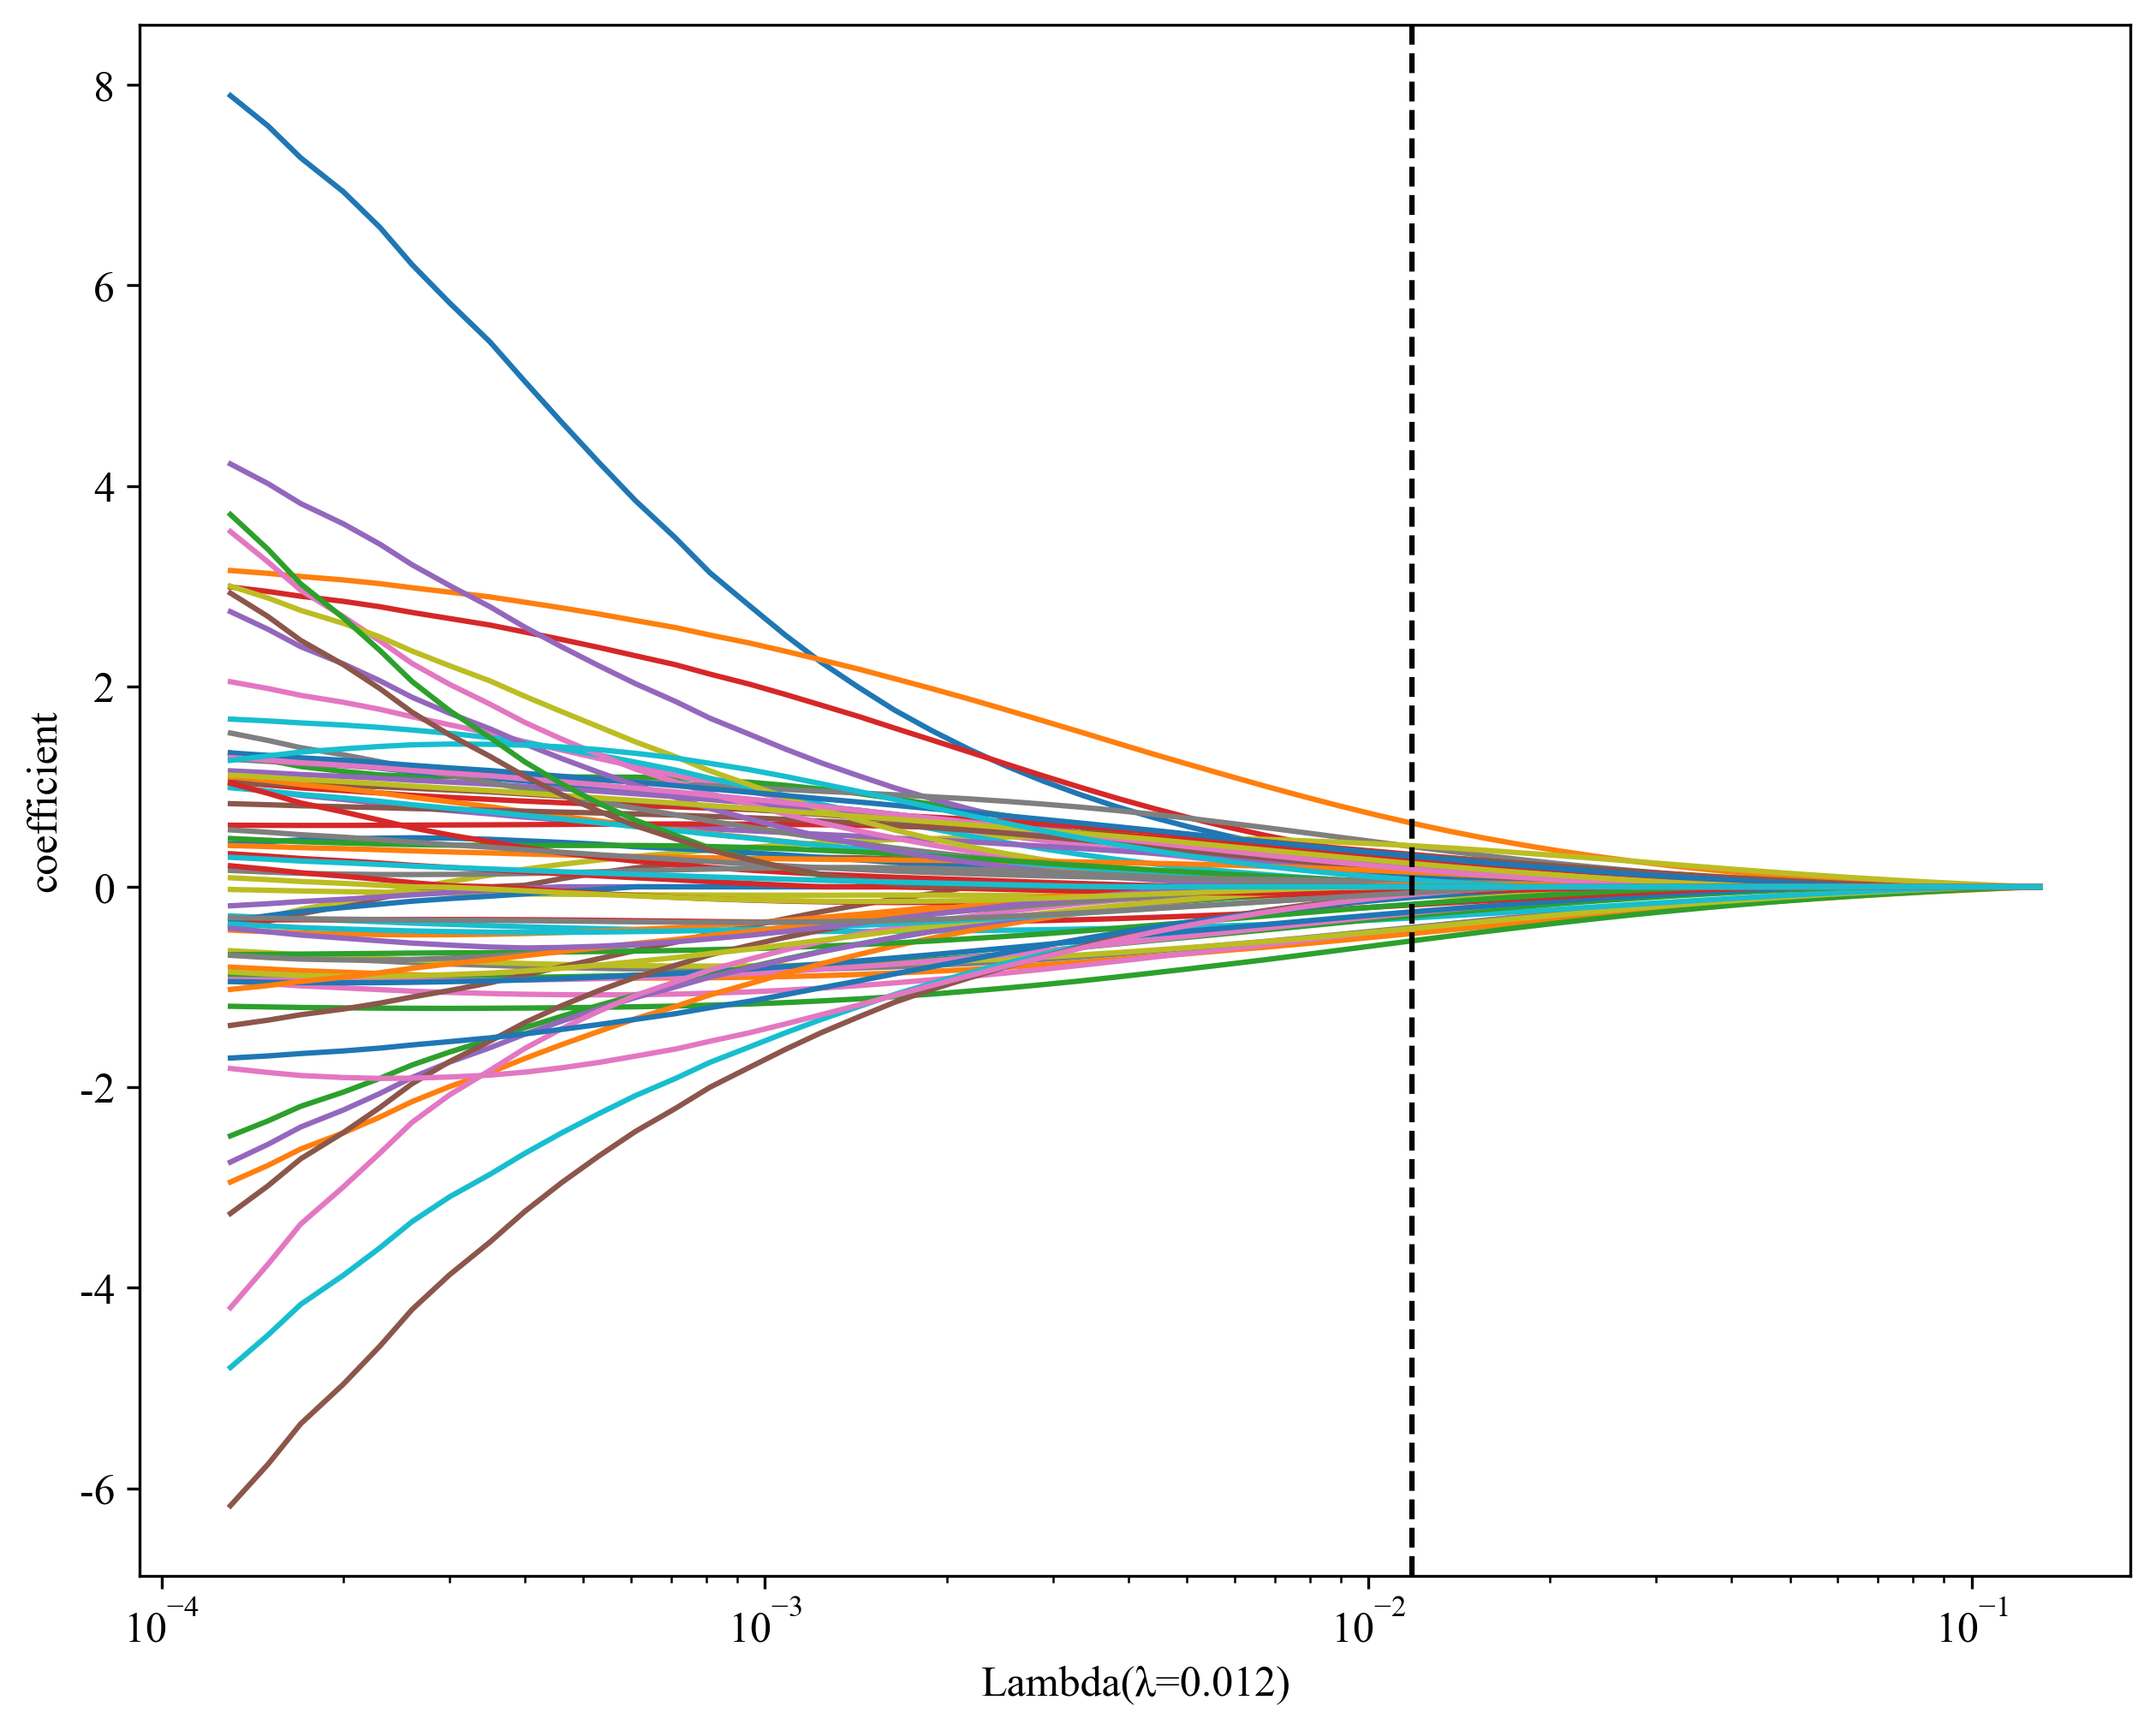

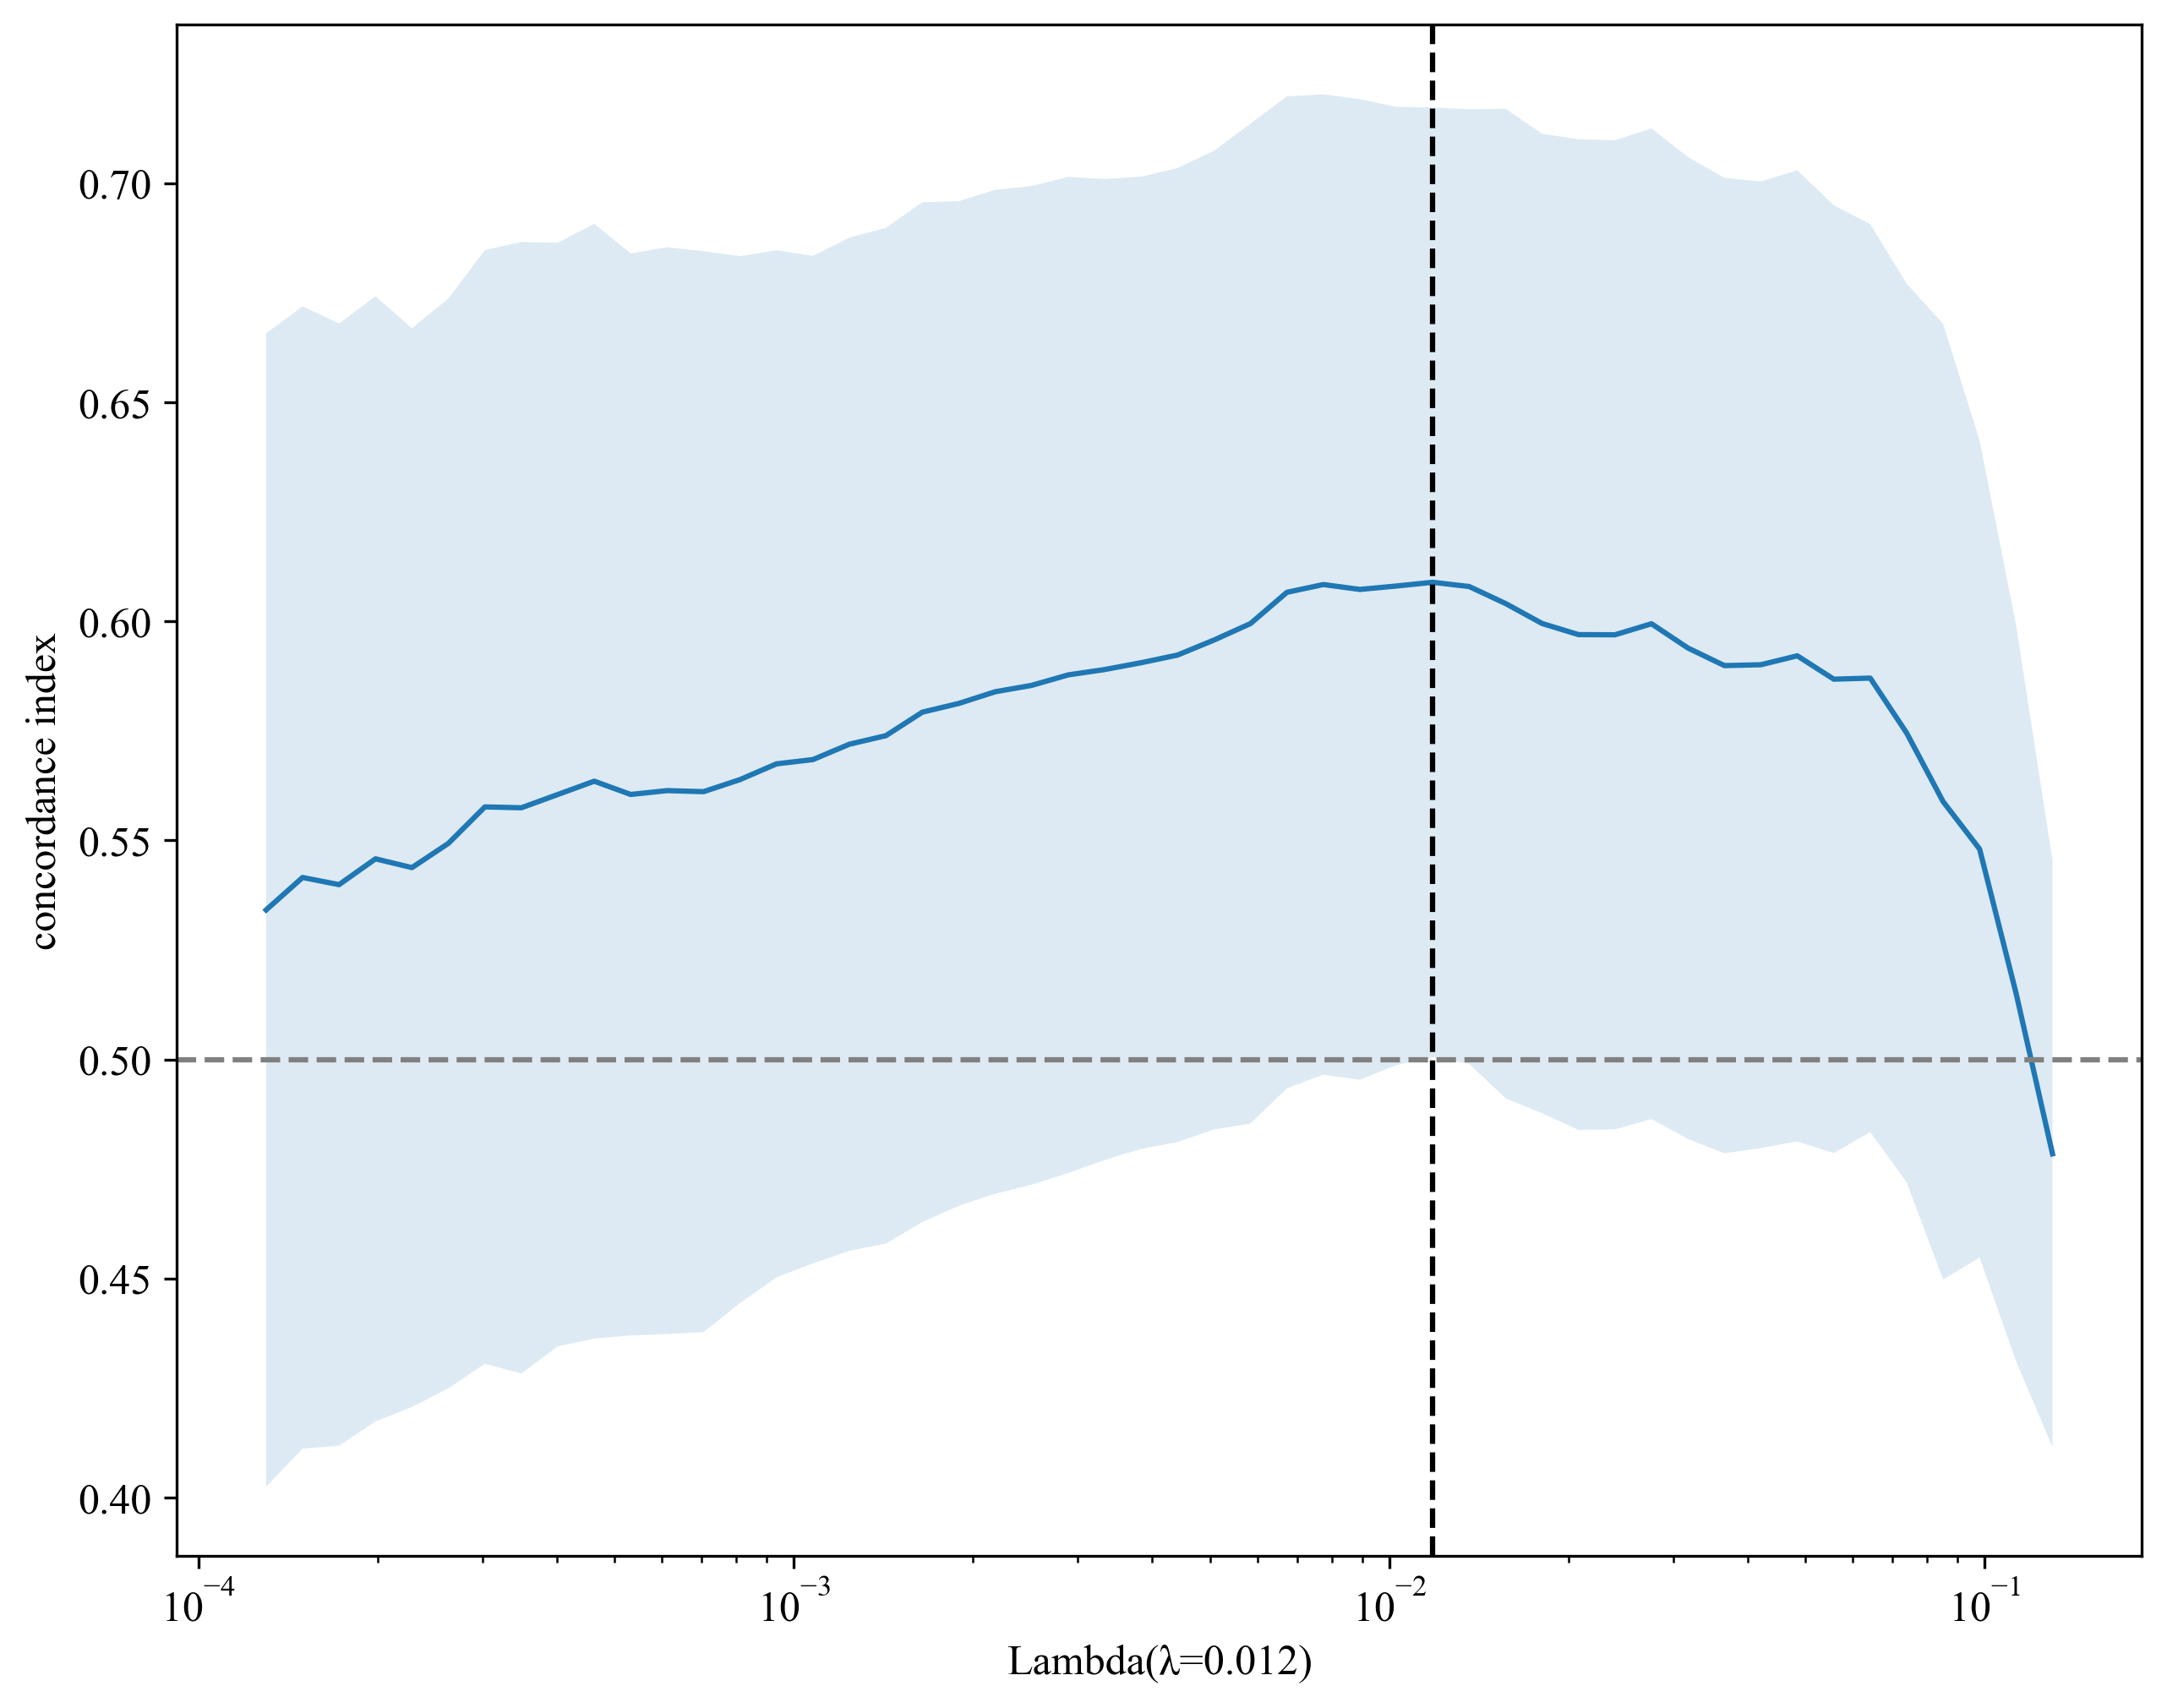

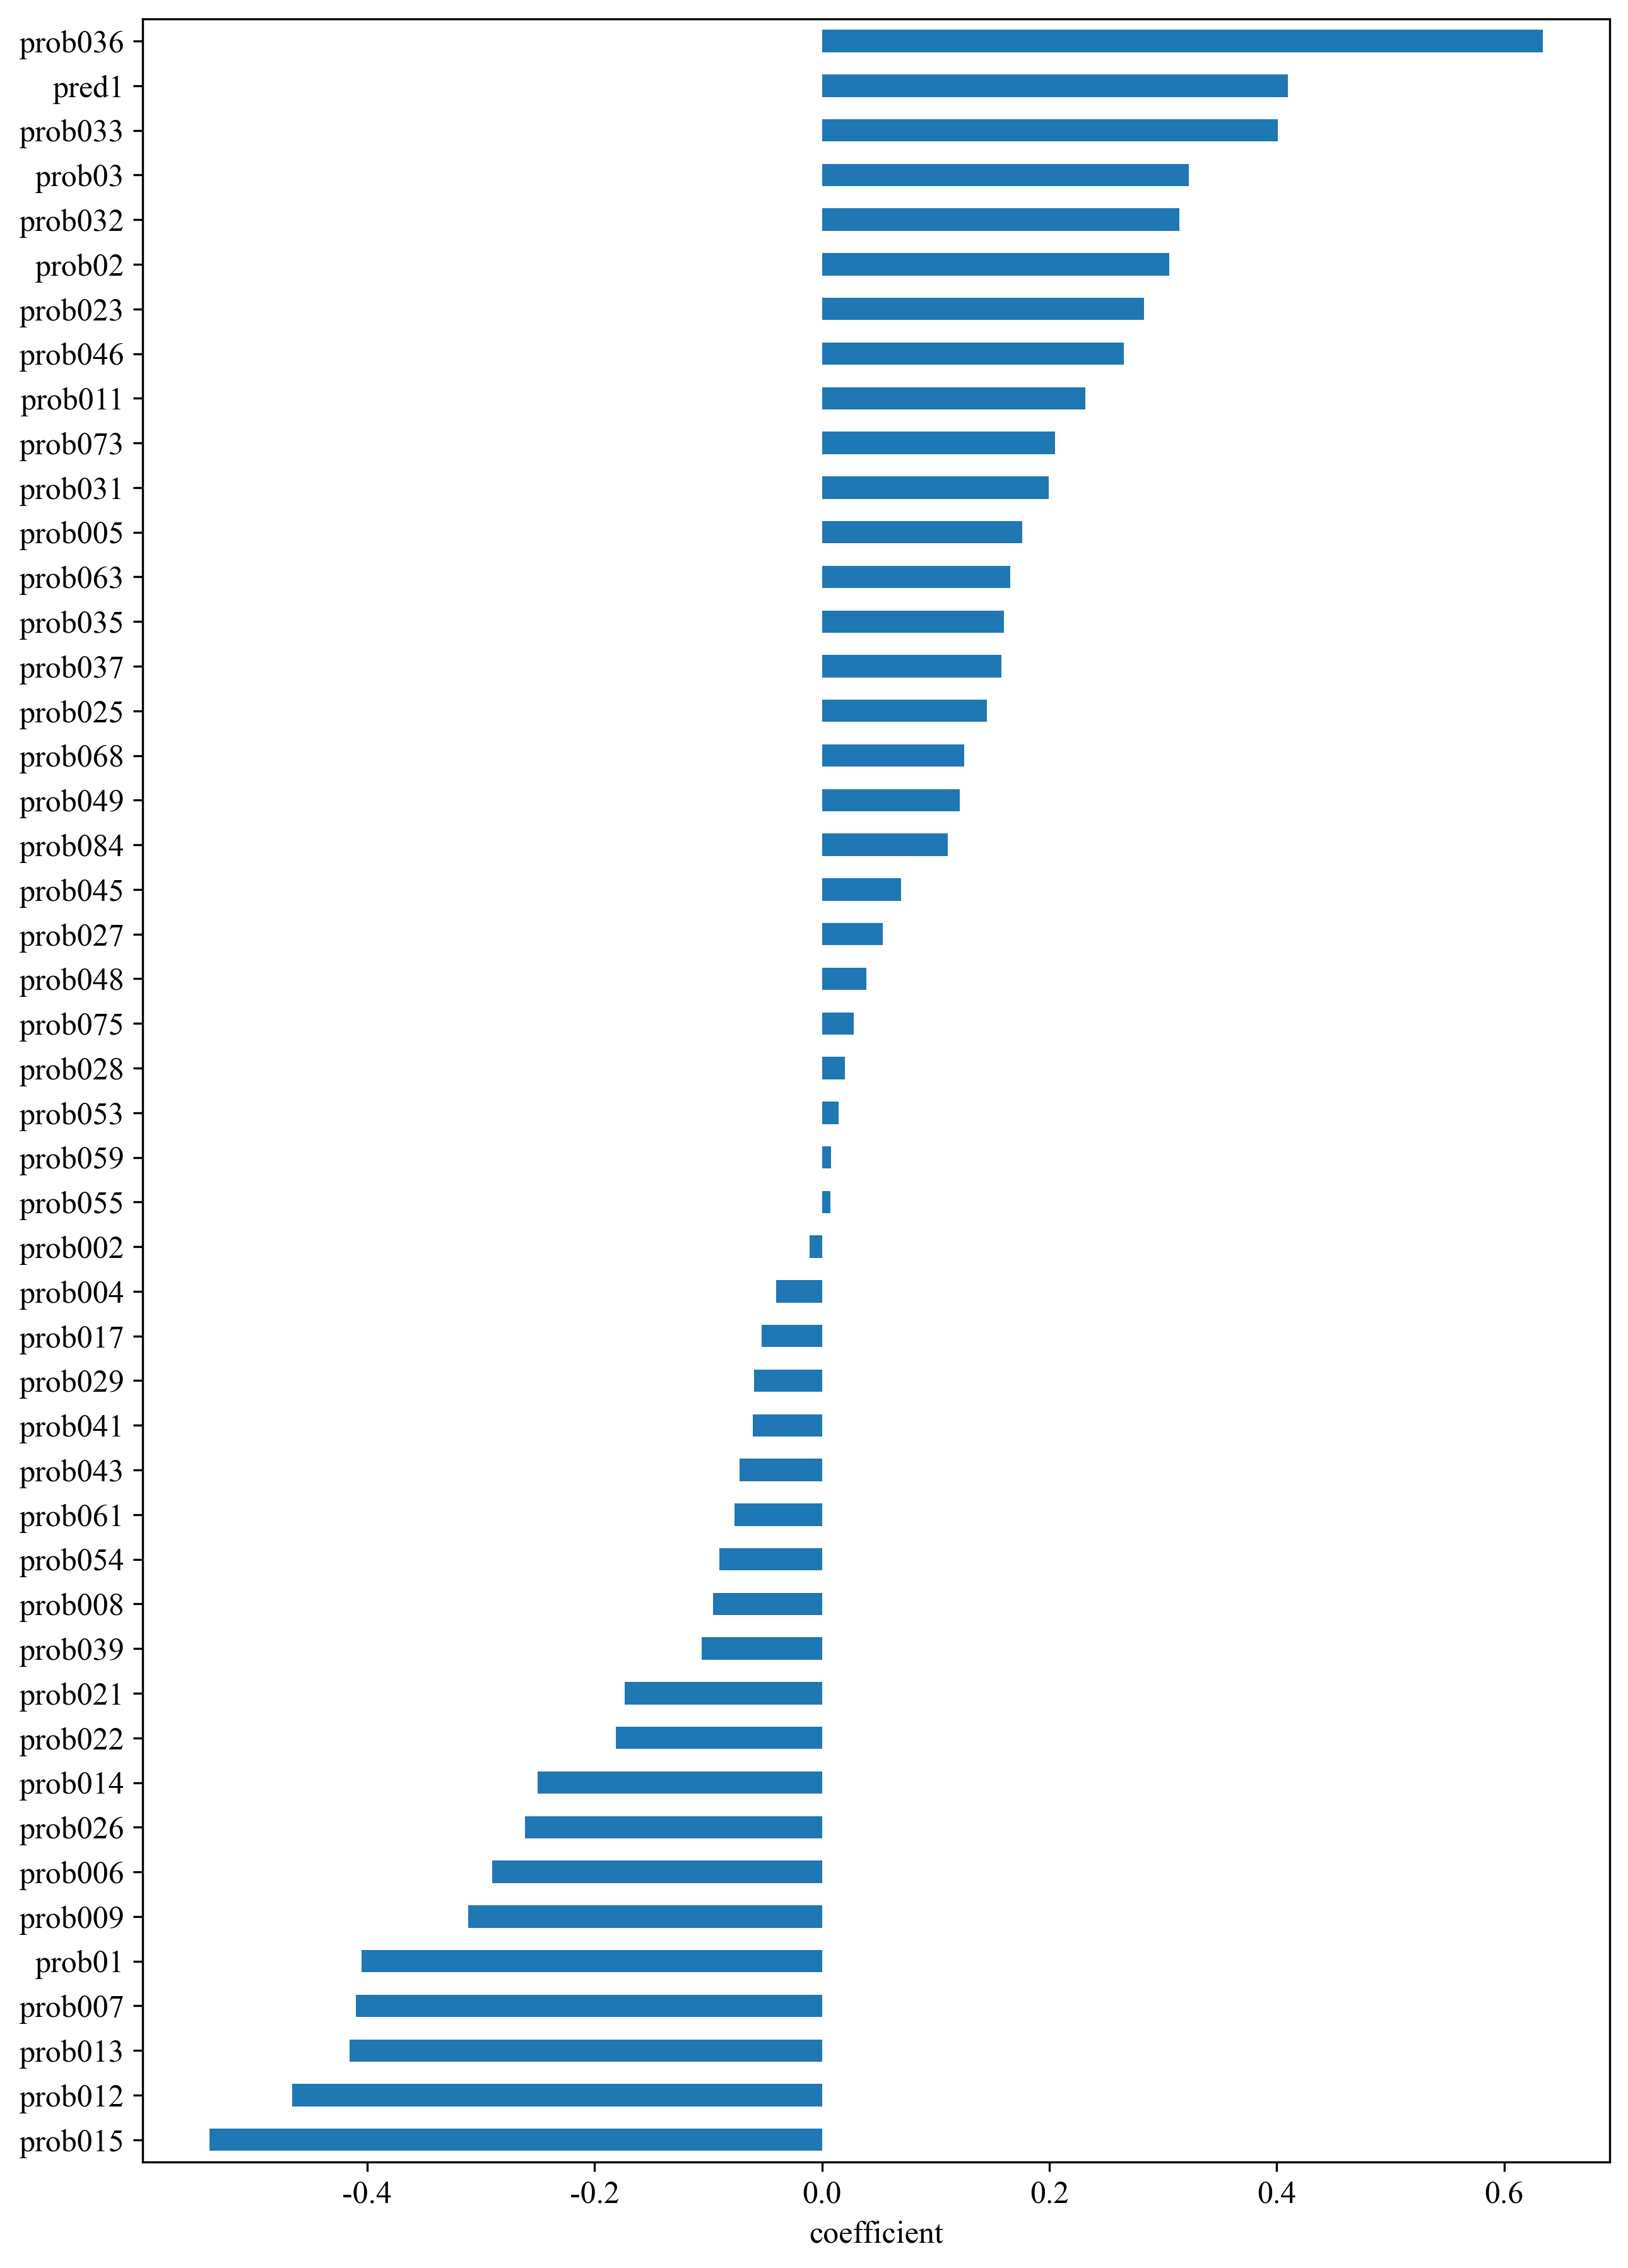

Survive = -0.538715 * prob015 -0.465628 * prob012 -0.415190 * prob013 -0.409910 * prob007 -0.404737 * prob01 -0.311139 * prob009 -0.289846 * prob006 -0.261064 * prob026 -0.249700 * prob014 -0.181089 * prob022 -0.173475 * prob021 -0.105676 * prob039 -0.095645 * prob008 -0.089934 * prob054 -0.077048 * prob061 -0.072474 * prob043 -0.060989 * prob041 -0.059895 * prob029 -0.052850 * prob017 -0.040479 * prob004 -0.010778 * prob002 +0.007336 * prob055 +0.008232 * prob059 +0.014598 * prob053 +0.020043 * prob028 +0.028251 * prob075 +0.039002 * prob048 +0.053405 * prob027 +0.069387 * prob045 +0.110630 * prob084 +0.121030 * prob049 +0.125248 * prob068 +0.145354 * prob025 +0.157742 * prob037 +0.160100 * prob035 +0.165804 * prob063 +0.176197 * prob005 +0.199406 * prob031 +0.205215 * prob073 +0.231814 * prob011 +0.265364 * prob046 +0.283264 * prob023 +0.305339 * prob02 +0.314397 * prob032 +0.322782 * prob03 +0.400663 * prob033 +0.409741 * pred1 +0.634042 * prob036


In [7]:
from onekey_algo.custom.components.survival import get_x_y_survival, lasso_cox_cv
COEF_THRESHOLD = 1e-6

X, y = get_x_y_survival(train_data, val_outcome=1, event_col=event_col, duration_col=duration_col)
sel_features = lasso_cox_cv(X, y, max_iter=100,  norm_X=False, prefix=f"{task_type}", l1_ratio=0.1, cv=10, weights_fig_size=(10, 15))
# sel_features = lasso_cox_cv(X, y, max_iter=1000,  norm_X=False, prefix=f"{task}_", l1_ratio=0.8, cv=10)

In [8]:
train_data = train_data[['ID'] + list(sel_features.index) + [event_col, duration_col]]
for subset in subsets:
    val_datasets[subset] = val_datasets[subset][['ID'] + list(sel_features.index) + [event_col, duration_col]]
    val_datasets[subset].to_csv(f'features/{task_type}{subset}_cox.csv', index=False)

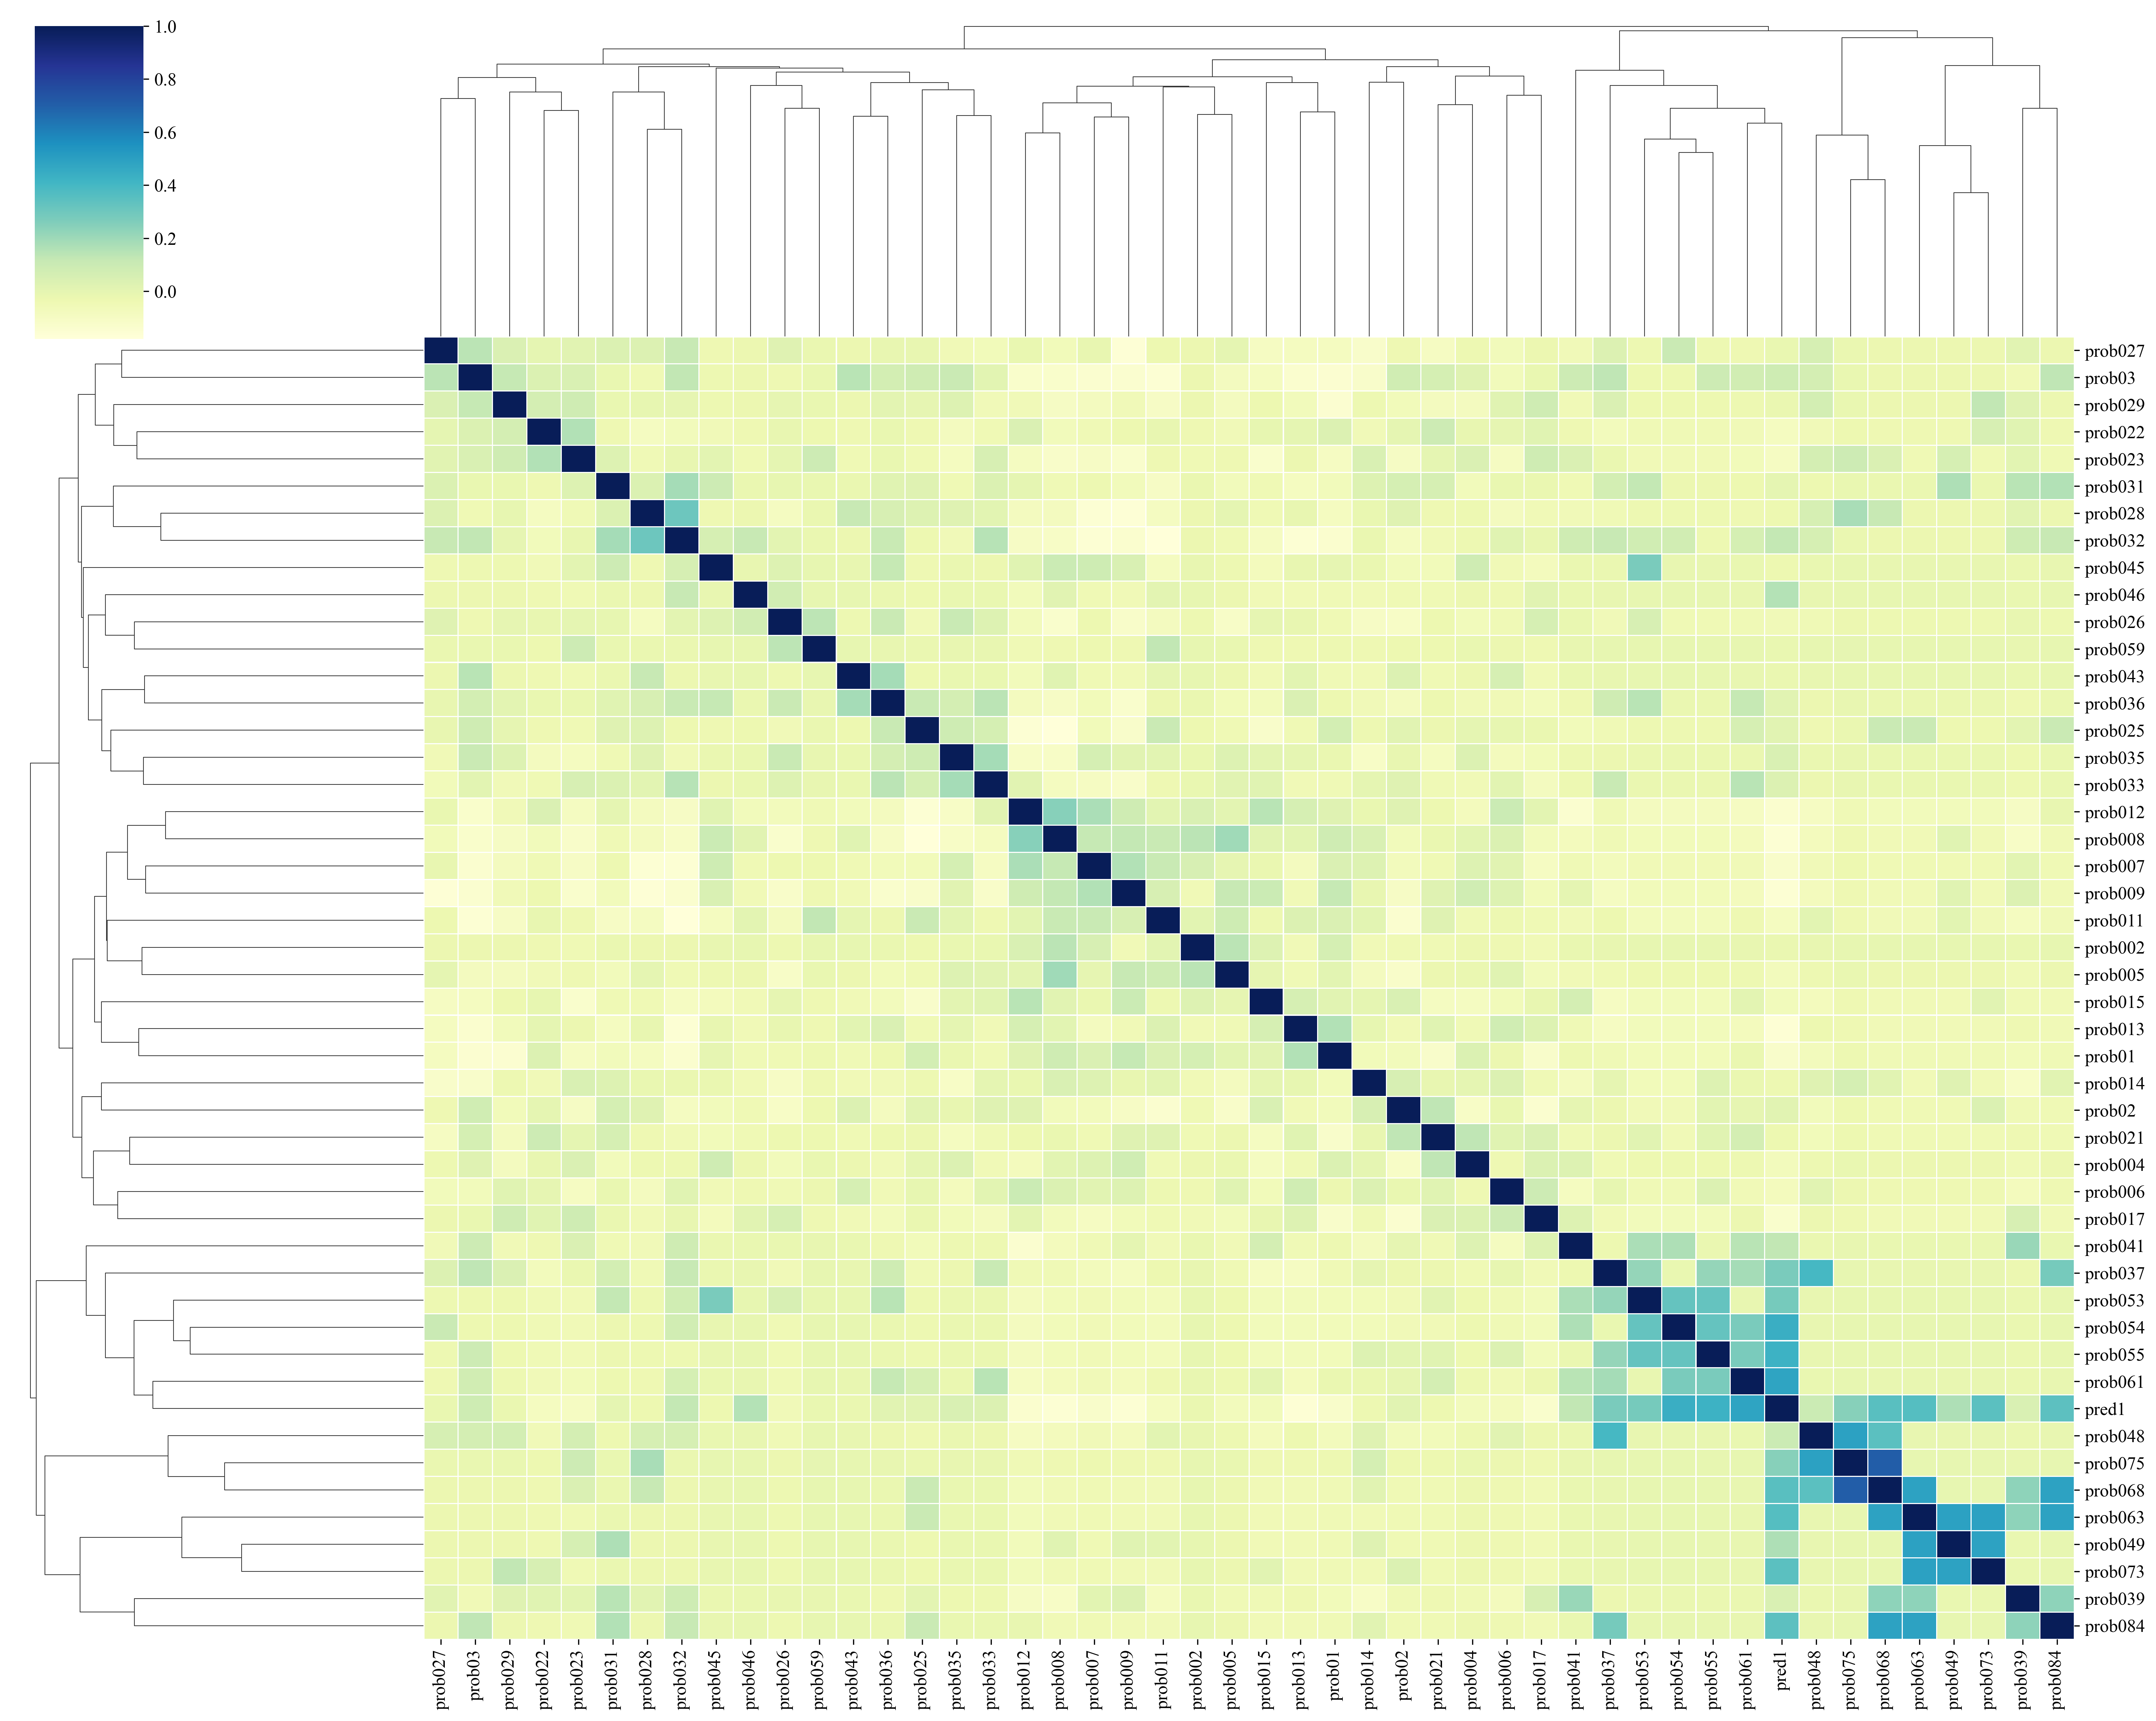

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

if train_data.shape[1] < 150:
    pp = sns.clustermap(train_data[[c for c in train_data.columns if c not in [event_col, duration_col]]].corr(corr_name), 
                        linewidths=.5, figsize=(20.0, 16.0), cmap='YlGnBu')
    plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
    plt.savefig(f'img/{task_type}feature_cluster.svg', bbox_inches = 'tight')

## Cox概览

所有Cox回归的必要数据，主要关注的数据有3个
1. `Concordance`: c-index
2. `exp(coef)`: 每个特征对应的HR，同时也有期对应的95%分位数。
3. `p`: 表示特征是否显著。

In [10]:
# from lifelines import CoxPHFitter
# mci = 0
# for p in range(1, 100):
#     cph = CoxPHFitter(penalizer=p/100)
#     cph.fit(train_data[[c for c in train_data.columns if c != 'ID']], duration_col=duration_col, event_col=event_col)
#     test_data = val_datasets['test']
#     ci = cph.score(test_data[[c for c in test_data.columns if c != 'ID']], scoring_method="concordance_index")
#     if mci < ci:
#         print(p, ci)
#         mci = ci

In [11]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.53)
cph.fit(train_data[[c for c in train_data.columns if c not in ['ID', 'group']]], duration_col=duration_col, event_col=event_col)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 268 total observations, 186 right-censored observations>
             duration col = 'DFSTIME'
                event col = 'DFS'
                penalizer = 0.53
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 268
number of events observed = 82
   partial log-likelihood = -422.86
         time fit was run = 2024-09-15 15:50:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
prob015    -0.43       0.65       0.40            -1.22             0.36                 0.30                 1.43
prob012    -0.38       0.68       0.40            -1.16             0.40                 0.31                 1.50
prob013    -0.35       0.71       0.41            -1.15             0.45                 0.32                 1.57
prob007    -0.45       0.64       0.51            -1.44             0.54                 0.24                 1.72
prob01     -0.34       0.71       0.42            -1.15             0.48                 0.32                 1.61
prob009    -0.25       0.78       0.40            -1.03             0.53                 0.36                 1.70
prob006    -0.33       0.72       0.49            -1.29             0.62                 0.28                 1.86
prob026    -0.33       0.72       0.47            -1.26             0.60                 0.28                 1.81
prob014    -0.24       0.78       0.39            -1.01             0.53                 0.36                 1.69
prob022    -0.17       0.84       0.42            -1.00             0.66                 0.37                 1.93
prob021    -0.16       0.86       0.43            -1.01             0.69                 0.37                 2.00
prob039    -0.44       0.64       0.77            -1.96             1.07                 0.14                 2.92
prob008    -0.10       0.91       0.39            -0.86             0.67                 0.42                 1.95
prob054    -1.73       0.18       1.97            -5.58             2.12                 0.00                 8.34
prob061    -0.58       0.56       1.12            -2.77             1.61                 0.06                 5.01
prob043    -1.20       0.30       1.52            -4.18             1.78                 0.02                 5.91
prob041    -0.19       0.82       0.81            -1.79             1.40                 0.17                 4.05
prob029    -0.14       0.87       0.52            -1.17             0.89                 0.31                 2.43
prob017    -0.03       0.97       0.39            -0.79             0.73                 0.46                 2.08
prob004    -0.16       0.86       0.63            -1.40             1.08                 0.25                 2.96
prob002    -0.85       0.43       1.62            -4.03             2.33                 0.02                10.33
prob055     0.92       2.52       1.37            -1.76             3.61                 0.17                36.88
prob059     1.02       2.77       1.57            -2.05             4.09                 0.13                59.93
prob053     0.81       2.26       1.23            -1.59             3.22                 0.20                24.90
prob028     0.07       1.07       0.47            -0.86             0.99                 0.42                 2.70
prob075     1.86       6.40       2.28            -2.62             6.33                 0.07               562.68
prob048     0.31       1.37       1.13            -1.91             2.54                 0.15                12.63
prob027     0.25       1.28       0.55            -0.82             1.32                 0.44                 3.74
prob045     0.63       1.88       1.02            -1.38             2.64                 0.25                13.97
prob084     1

#### 输出每个特征的HR

In [12]:
cph.concordance_index_

0.7350384486793714

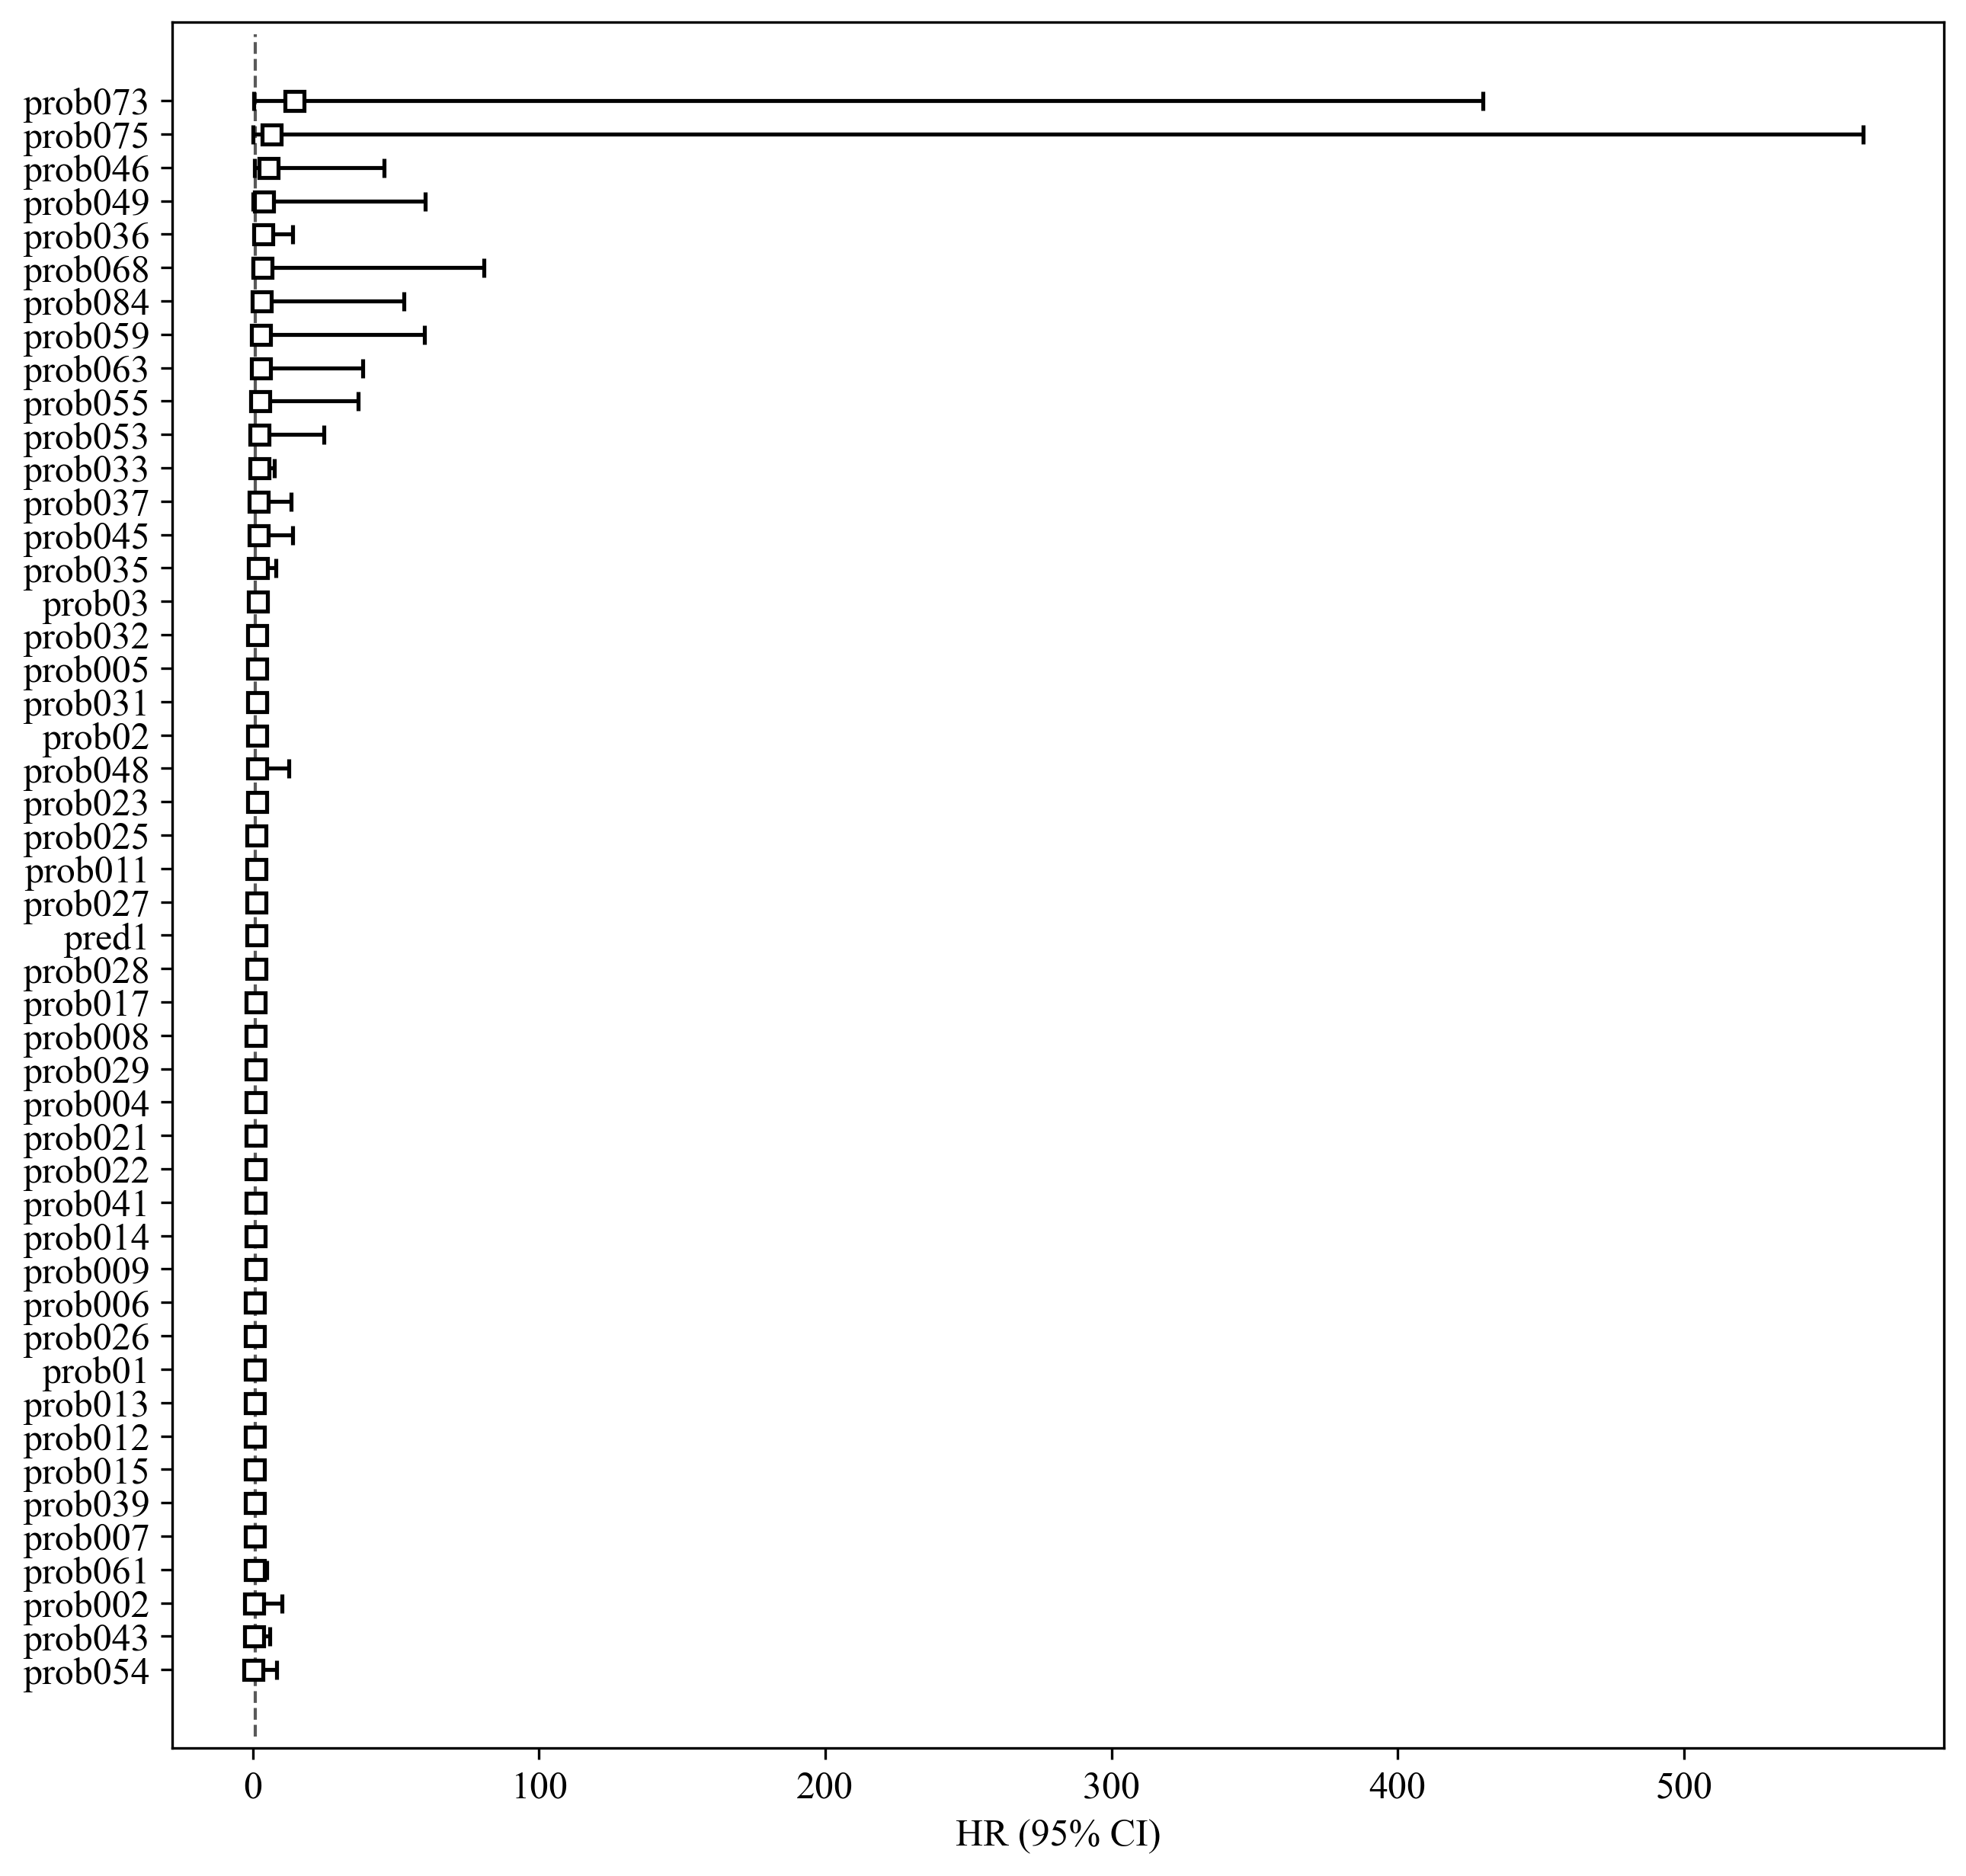

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
cph.plot(hazard_ratios=True)
plt.savefig('img/Clinic_feature_pvalue.svg')
plt.show()

# KM 曲线

根据HR进行分组，计算KM以及log ranktest

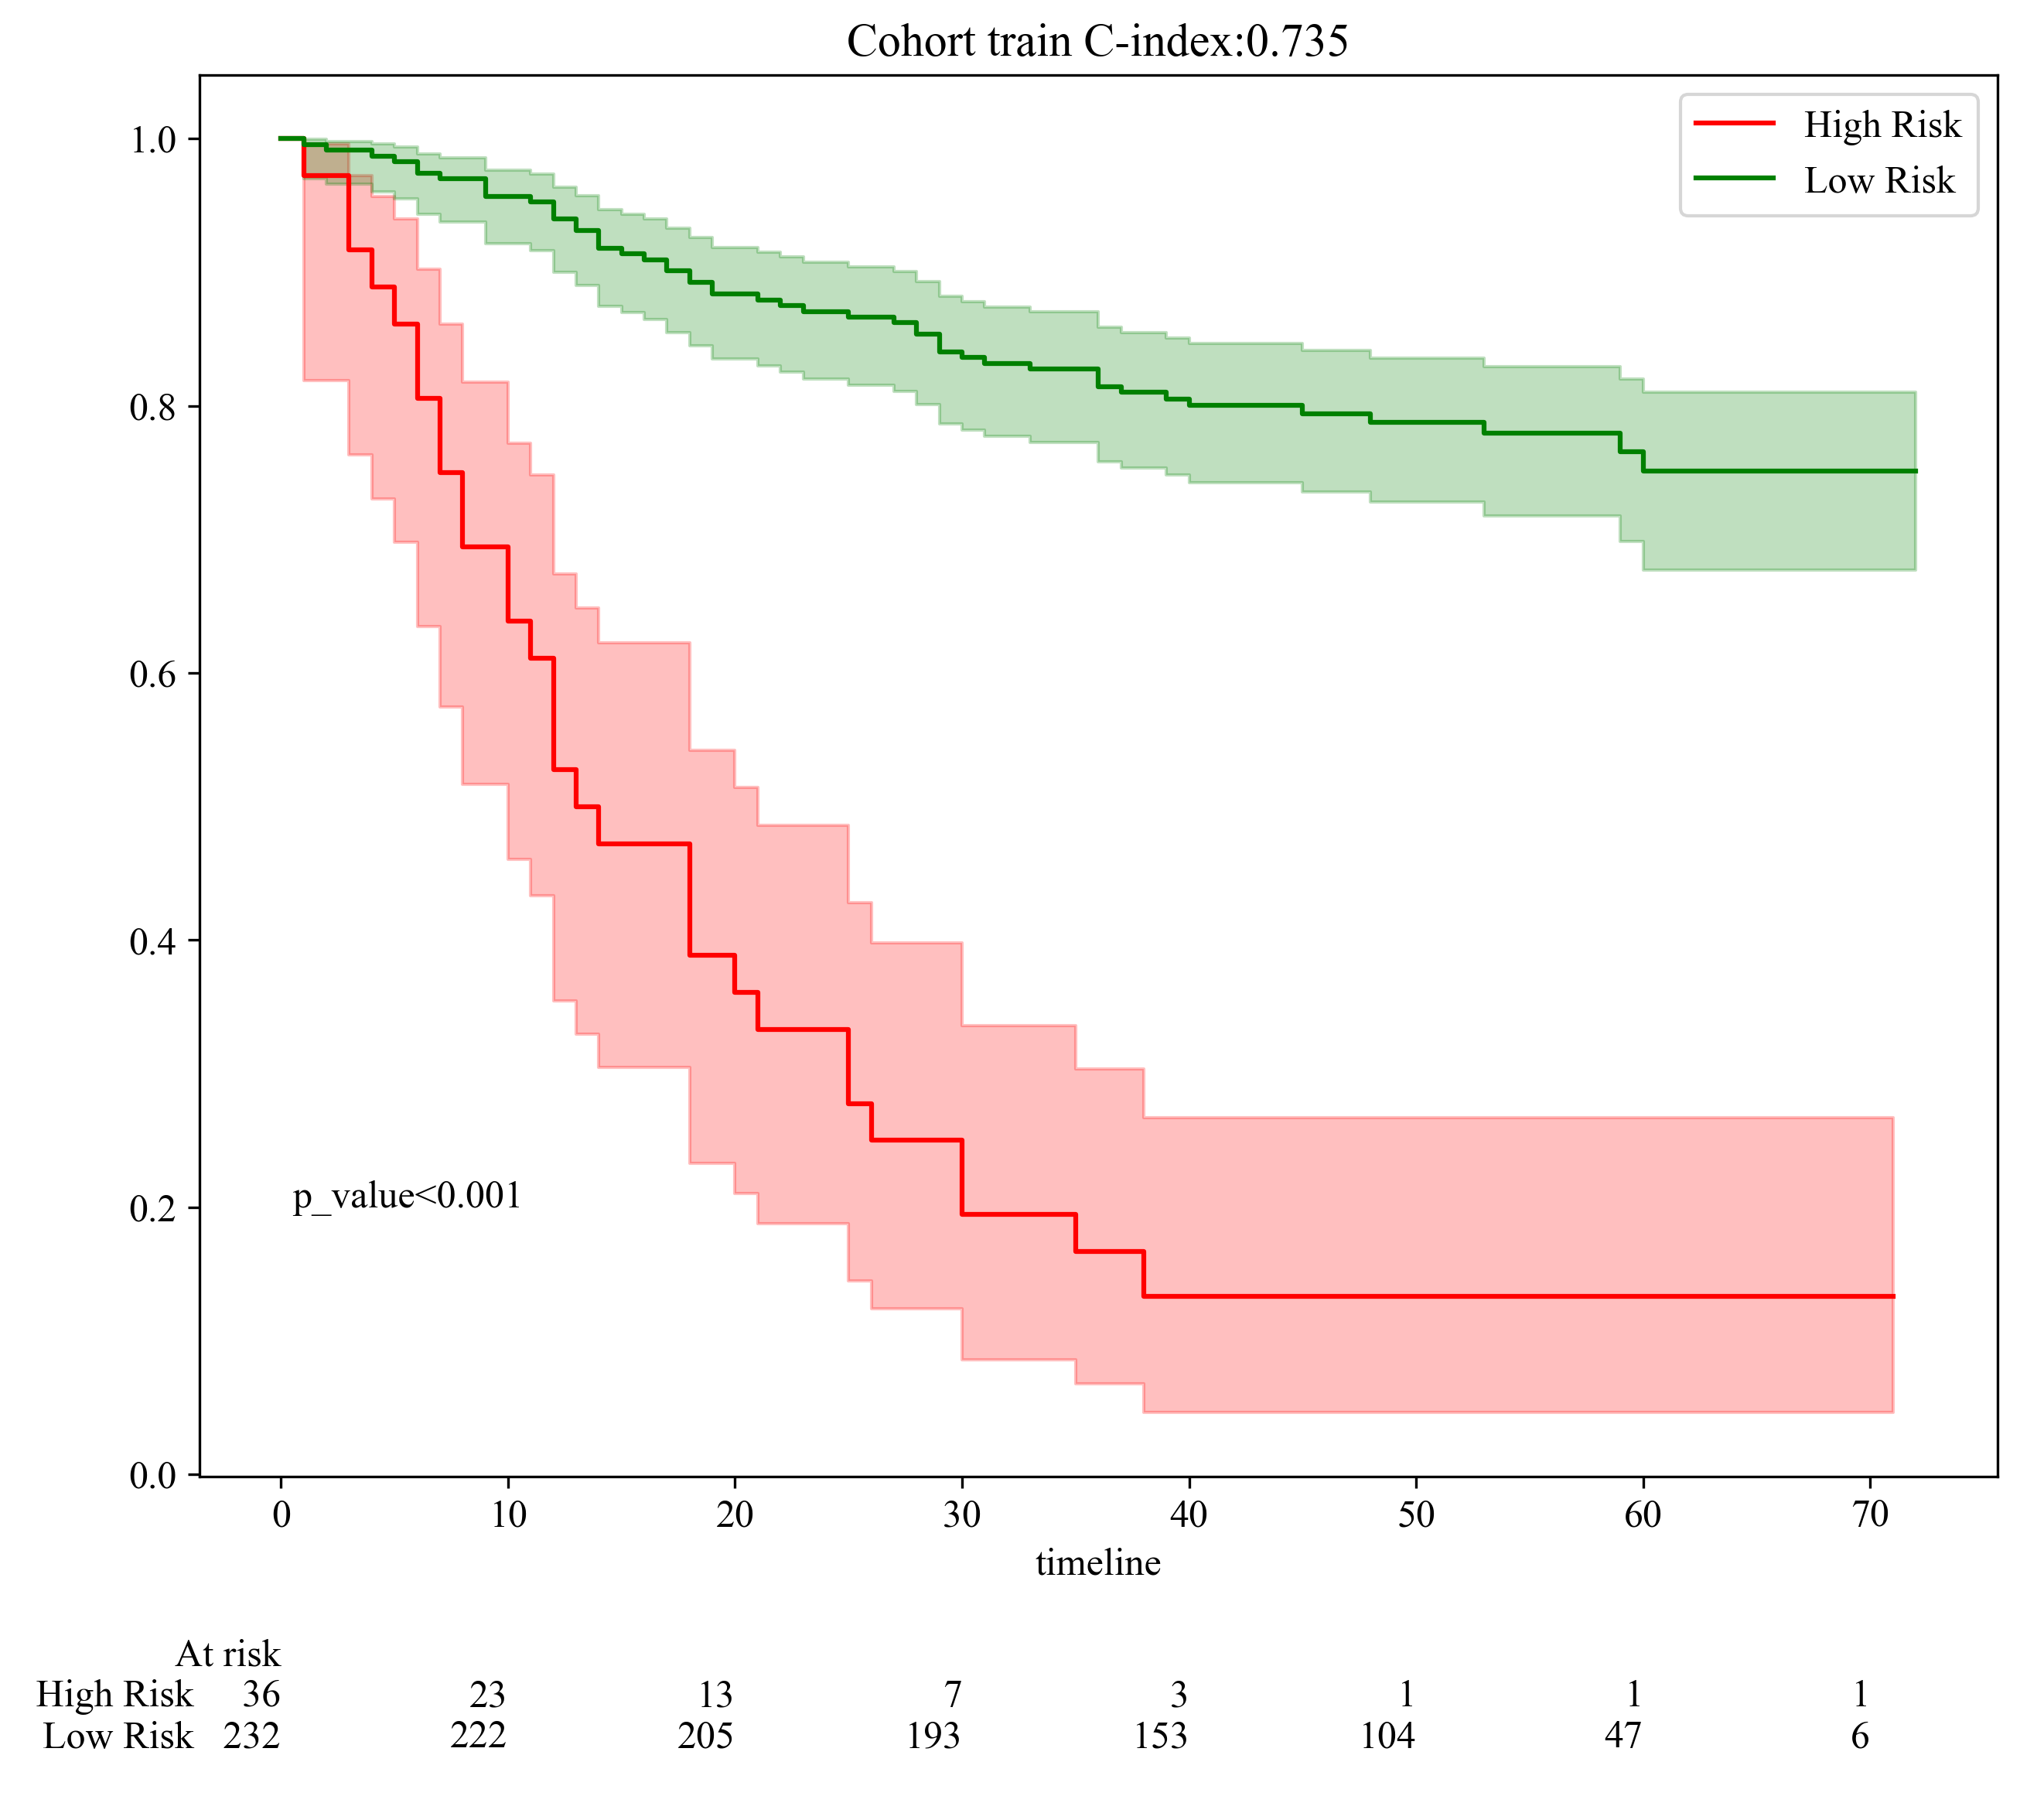

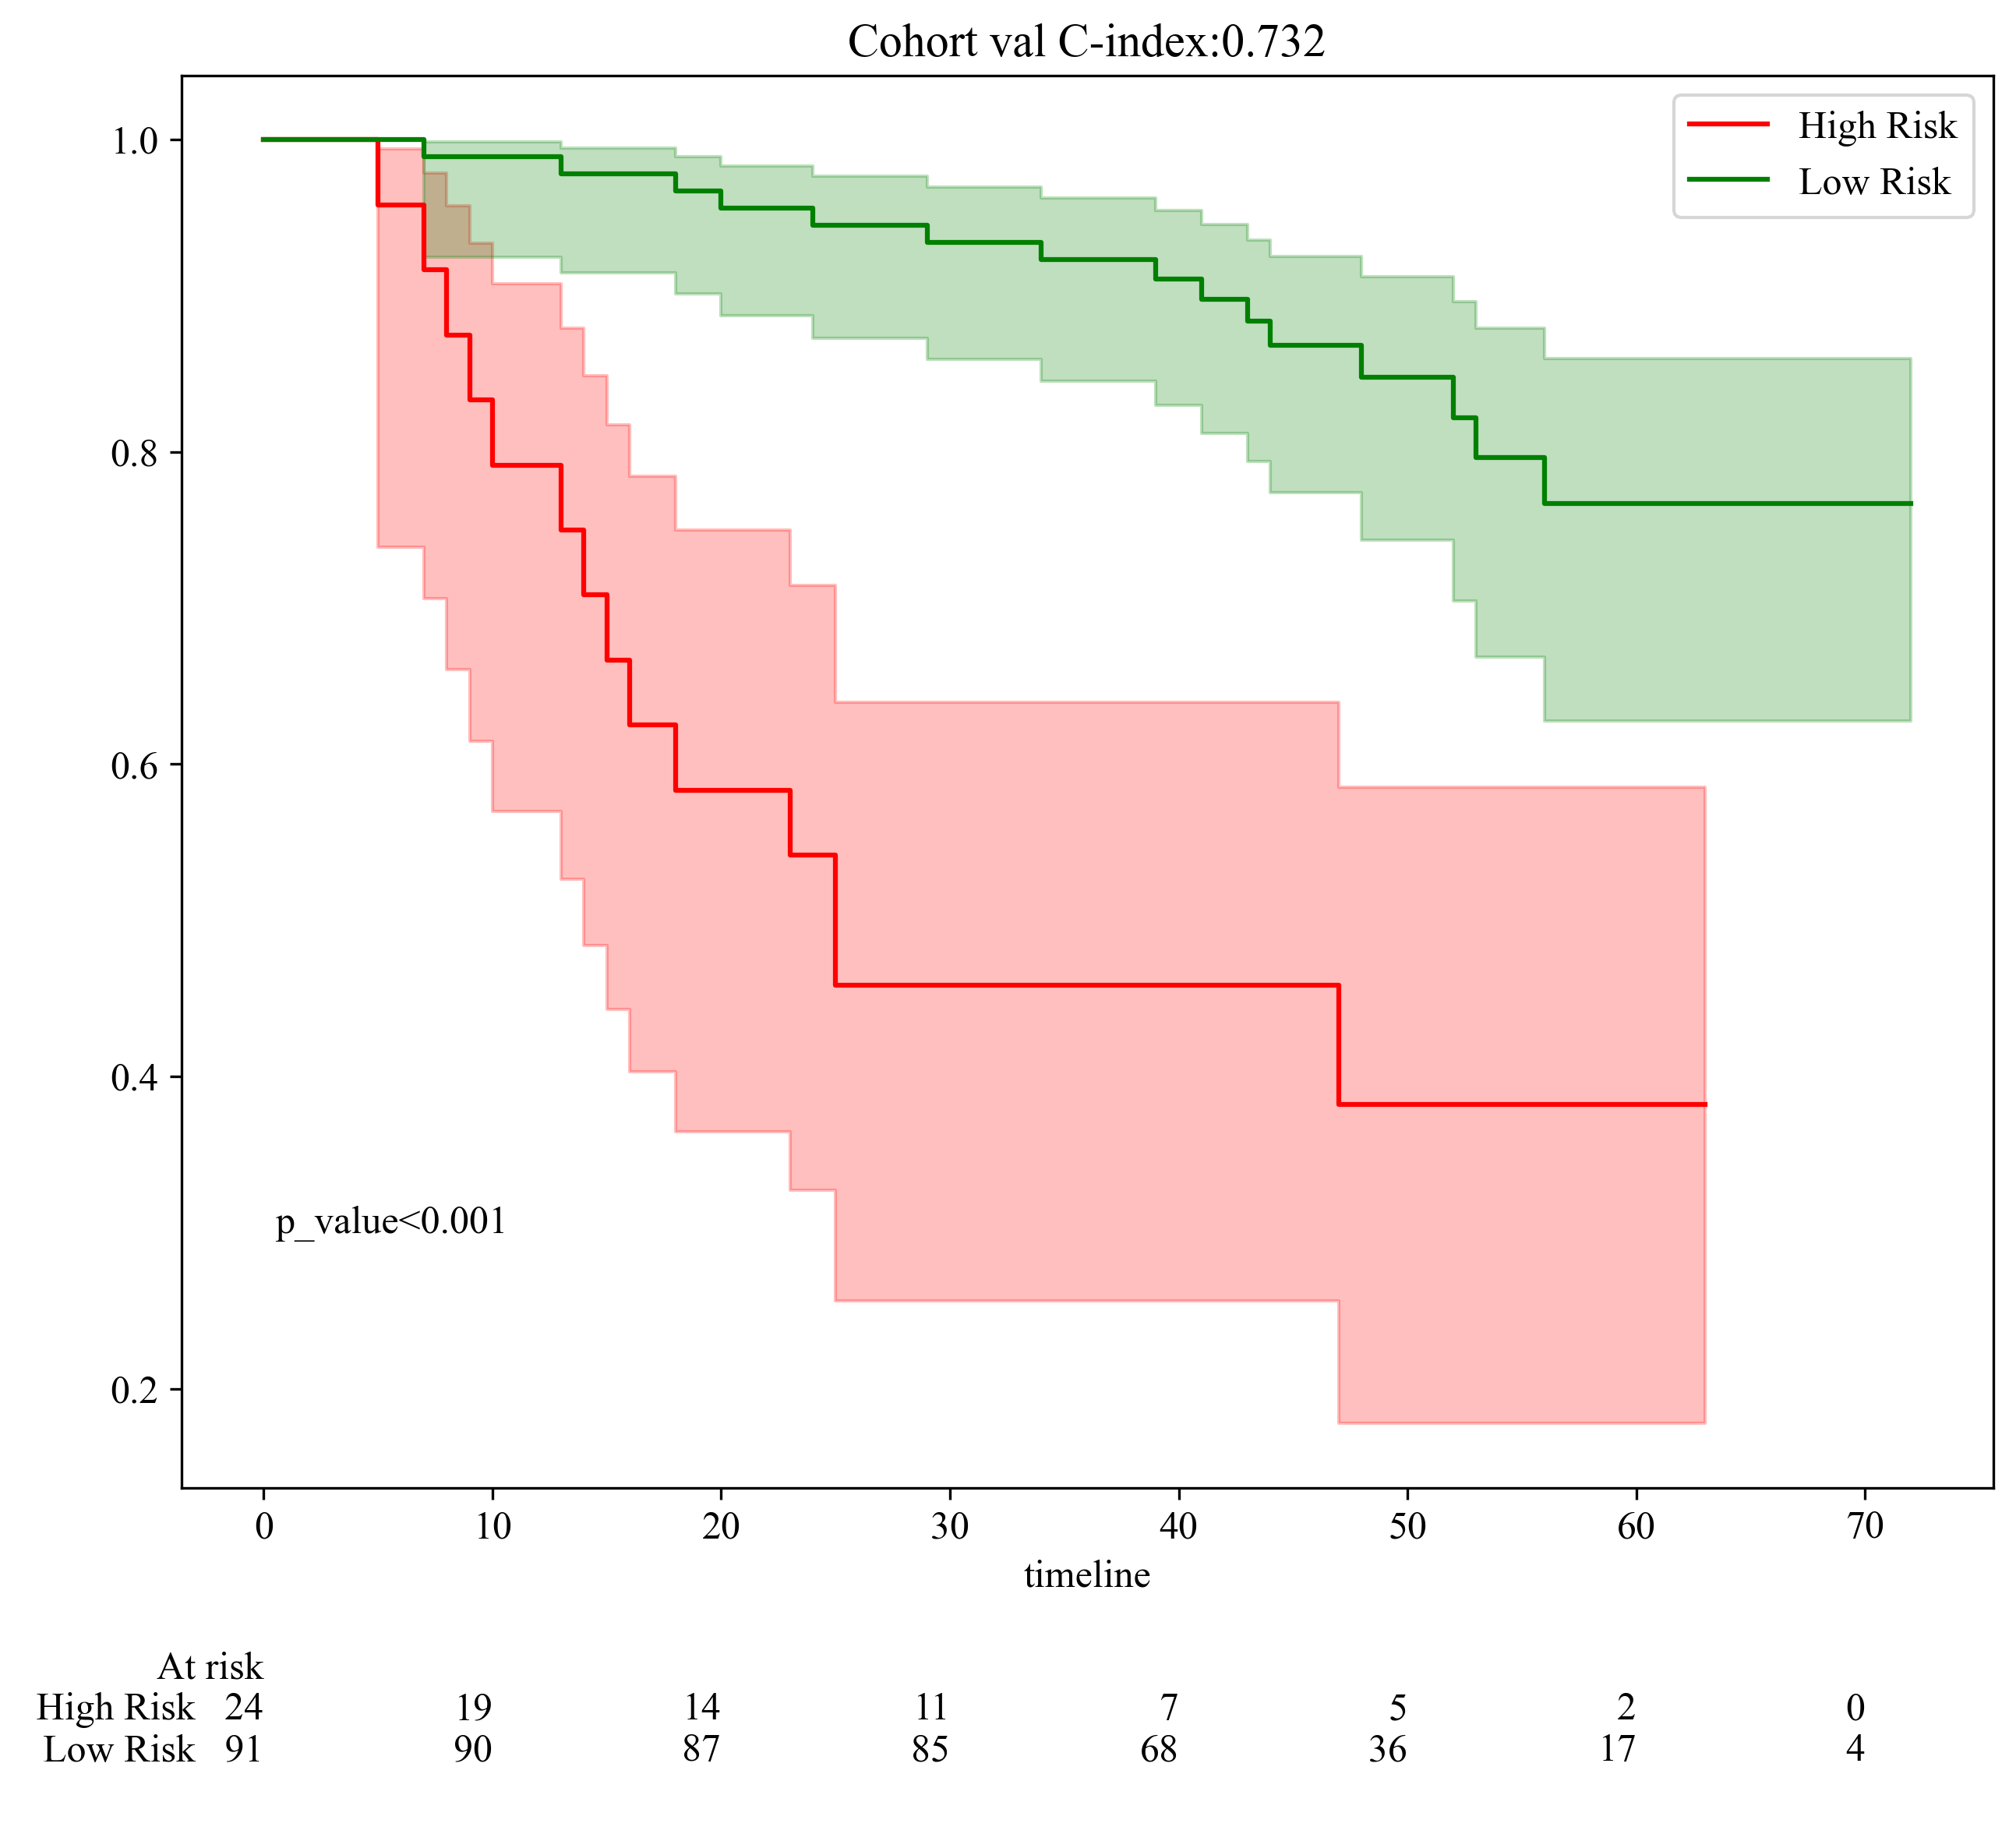

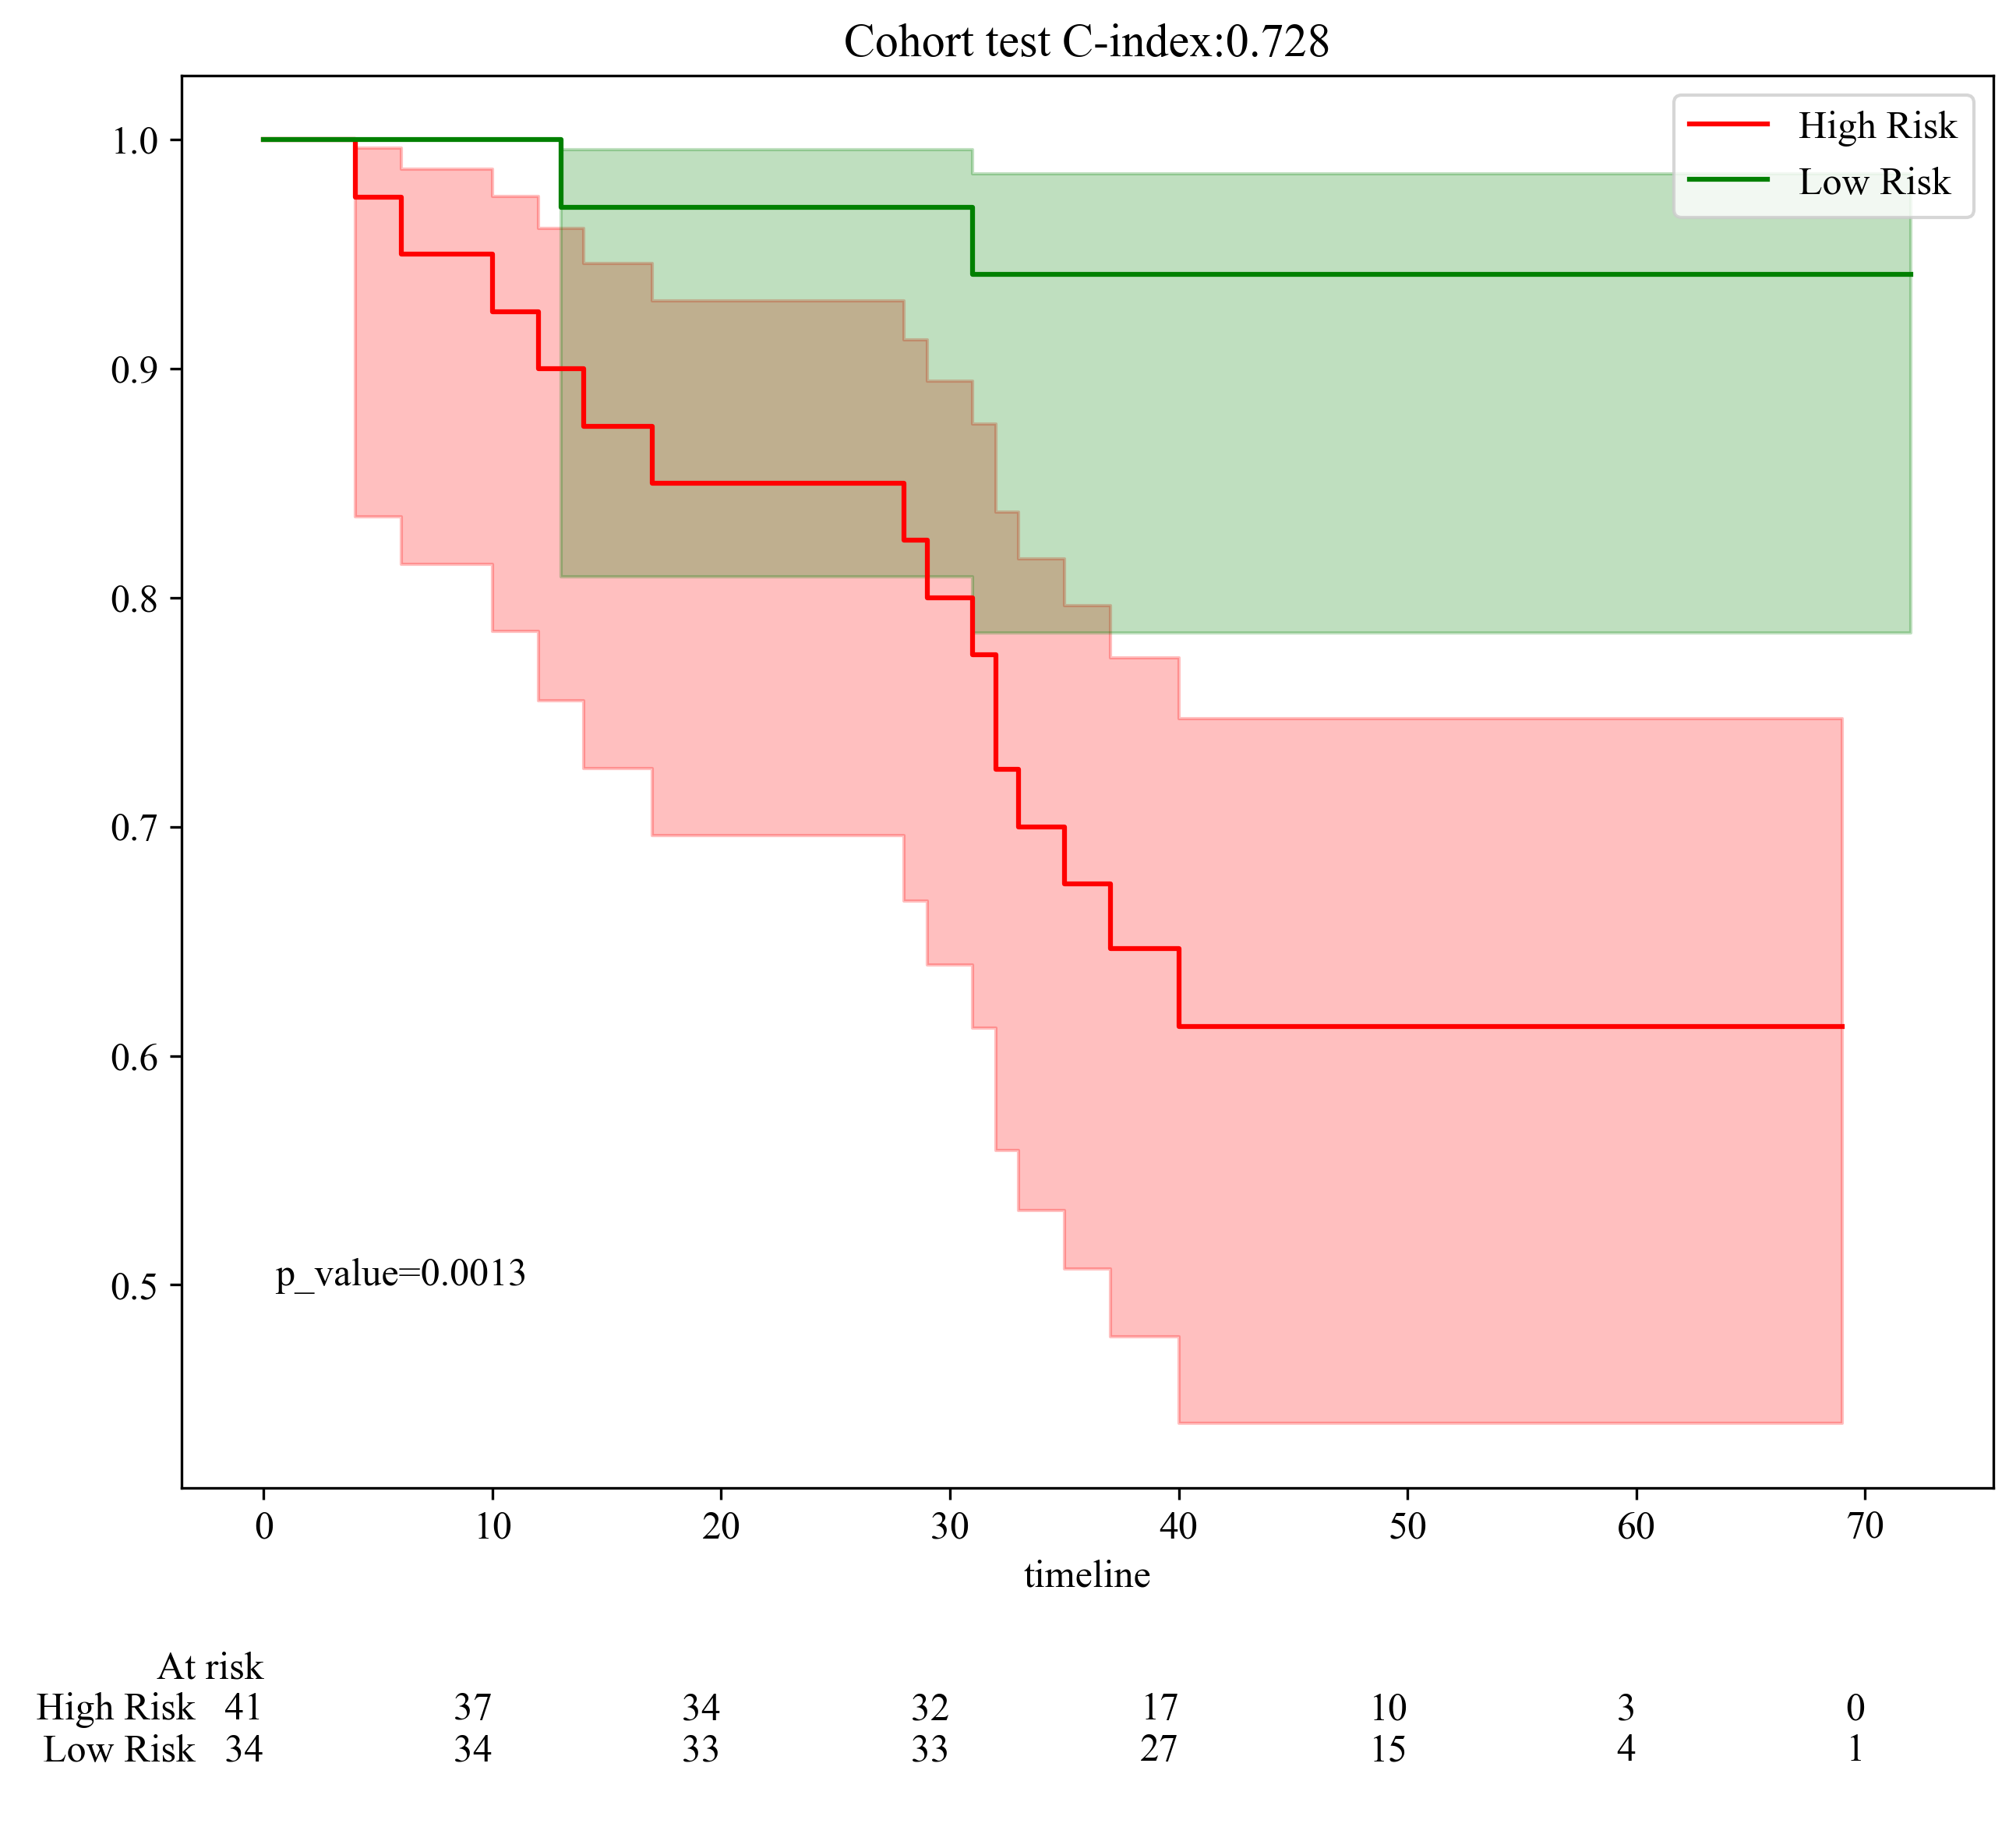

In [19]:
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

thres = 0.001
bst_split = {'train': 1.49, 'val':1.23, 'test': 0.97}
loc = {'train': 0.2, 'val':0.3, 'test': 0.5}
for subset, test_data in val_datasets.items():
    c_index = cph.score(test_data[[c for c in test_data.columns if c != 'ID']], scoring_method="concordance_index")
#     y_pred = cph.predict_median(test_data[[c for c in test_data.columns if c != 'ID']])
#     cox_data = pd.concat([test_data, y_pred], axis=1)
#     mean = cox_data.describe()[0.5]['mean']
#     cox_data['HR'] = cox_data[0.5] < mean
    y_pred = cph.predict_partial_hazard(test_data[[c for c in test_data.columns if c != 'ID']])
    cox_data = pd.concat([test_data, y_pred], axis=1)
    mean = cox_data.describe()[0]['50%']
    cox_data['HR'] = cox_data[0] > bst_split[subset]
#     cox_data['HR'] = cox_data[0] > 1

    dem = (cox_data["HR"] == True)
    results = logrank_test(cox_data[duration_col][dem], cox_data[duration_col][~dem], 
                           event_observed_A=cox_data[event_col][dem], event_observed_B=cox_data[event_col][~dem])
    p_value = f"={results.p_value:.4f}" if results.p_value > thres else f'<{thres}'
    plt.title(f"Cohort {subset} C-index:{c_index:.3f}")
    if sum(dem):
        kmf_high = KaplanMeierFitter()
        kmf_high.fit(cox_data[duration_col][dem], event_observed=cox_data[event_col][dem], label="High Risk")
        kmf_high.plot_survival_function(color='r')
    if sum(~dem):
        kmf_low = KaplanMeierFitter()
        kmf_low.fit(cox_data[duration_col][~dem], event_observed=cox_data[event_col][~dem], label="Low Risk")
        kmf_low.plot_survival_function(color='g')
    plt.text(0.5, loc[subset], f"p_value{p_value}")
    add_at_risk_counts(kmf_high, kmf_low, rows_to_show=['At risk'])
    plt.savefig(f'img/{task_type}KM_{subset}.svg', bbox_inches='tight')
    plt.show()

In [16]:
import os
import numpy as np

def get_prediction(model: CoxPHFitter, data, ID=None, **kwargs):
    hr = model.predict_partial_hazard(data)
    expectation = model.predict_expectation(data)
    
    predictions = pd.concat([hr, expectation], axis=1)
    predictions.columns = ['HR', 'expectation']
    if ID is not None:
        predictions = pd.concat([ID, hr, expectation], axis=1)
        predictions.columns = ['ID', 'HR', 'expectation']
    else:
        predictions = pd.concat([hr, expectation], axis=1)
        predictions.columns = ['HR', 'expectation']
    return predictions

os.makedirs('results', exist_ok=True)
info = []
for subset, test_data in val_datasets.items():
    if subset in get_param_in_cwd('subsets'):
        results = get_prediction(cph, test_data, ID=test_data['ID'])
        results.to_csv(f'results/{task_type}cox_predictions_{subset}.csv', index=False)
        results['group'] = subset
        info.append(results)
        pd.merge(results, data[['ID', event_col, duration_col]], 
                 on='ID', how='inner').to_csv(f'features/{task_type}4xtile_{subset}.txt', index=False, sep='\t')
info = pd.concat(info, axis=0)
info

,ID,HR,expectation,group
0,primary-1.nii.gz,4.577,24.457,train
1,primary-10.nii.gz,1.196,51.879,train
2,primary-100.nii.gz,0.757,58.051,train
4,primary-102.nii.gz,2.428,38.514,train
6,primary-104.nii.gz,1.497,48.122,train
...,...,...,...,...
453,secondary2-69.nii.gz,0.422,63.391,test
454,secondary2-7.nii.gz,0.571,60.952,test
455,secondary2-71.nii.gz,0.764,57.955,test
456,secondary2-72.nii.gz,0.855,56.593,test


In [17]:
# info[['ID', 'group']].to_csv('group.csv', index=False)